In [1]:
# ENHANCED MOTOR LEARNING ANALYSIS WITH STRIDE CHANGE DISTRIBUTION
# Incorporates the stride change distribution plotting functionality
# ==============================================================================

import os
import re
import pickle
import tempfile
import webbrowser
from collections import defaultdict
from pathlib import Path
from typing import List, Dict, Tuple, Optional, Union

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, mannwhitneyu, gaussian_kde
import statsmodels.formula.api as smf

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (mean_squared_error, r2_score, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

from IPython.display import display, HTML
from tqdm import tqdm

In [2]:
# 1. CONFIGURATION
# ==============================================================================


class Config:
    """Enhanced configuration settings for the motor learning analysis."""
    
    def __init__(self, base_output_dir: str = 'motor_learning_output'):
        # Base directory for all outputs
        self.BASE_OUTPUT_DIR = Path(base_output_dir)
        self.BASE_OUTPUT_DIR.mkdir(exist_ok=True)
        
        # Create organized subdirectory structure
        self.FIGURES_DIR = self.BASE_OUTPUT_DIR / 'figures'
        self.INDIVIDUAL_PLOTS_DIR = self.FIGURES_DIR / 'individual_plots'
        self.POPULATION_PLOTS_DIR = self.FIGURES_DIR / 'population_plots'
        self.STATISTICAL_PLOTS_DIR = self.FIGURES_DIR / 'statistical_plots'
        self.REPORTS_DIR = self.BASE_OUTPUT_DIR / 'reports'
        self.EXPORTS_DIR = self.BASE_OUTPUT_DIR / 'exports'
        self.PROCESSED_DATA_DIR = self.BASE_OUTPUT_DIR / 'processed_data'
        
        # Create all directories
        for directory in [self.FIGURES_DIR, self.INDIVIDUAL_PLOTS_DIR, 
                         self.POPULATION_PLOTS_DIR, self.STATISTICAL_PLOTS_DIR,
                         self.REPORTS_DIR, self.EXPORTS_DIR, self.PROCESSED_DATA_DIR]:
            directory.mkdir(parents=True, exist_ok=True)
        
        # File processing parameters
        self.MIN_COMPLETE_STRIDES = 20
        self.PROCESSED_DATA_FILE = self.PROCESSED_DATA_DIR / 'processed_data.pkl'
        
        # Trial type mappings
        self.TRIAL_TYPE_MAPPING = {
            'primer': 'vis1',
            'trial': 'invis', 
            'vis': 'vis2',
            'pref': 'pref'
        }
        
        # Analysis parameters
        self.MOTOR_NOISE_THRESHOLD = 0.3
        self.SUCCESS_RATE_THRESHOLD = 0.68
        self.TARGET_SIZE_THRESHOLD = 0.31
        self.MAX_STRIDES_THRESHOLD = 415
        
        # Visualization parameters
        self.FIGURE_DPI = 300
        self.ALPHA_LEVEL = 0.05
        self.AGE_BINS = [7, 10, 13, 16, 18]
        self.AGE_LABELS = ['7-10', '10-13', '13-16', '16-18']
        
        print(f"📁 Config initialized with base directory: {self.BASE_OUTPUT_DIR}")
        print(f"   📊 Figures: {self.FIGURES_DIR}")
        print(f"   📋 Reports: {self.REPORTS_DIR}")
        print(f"   💾 Exports: {self.EXPORTS_DIR}")

    def get_figure_path(self, filename: str, subdir: str = 'general') -> Path:
        """Get standardized figure path with automatic subdirectory creation."""
        if subdir == 'individual':
            target_dir = self.INDIVIDUAL_PLOTS_DIR
        elif subdir == 'population':
            target_dir = self.POPULATION_PLOTS_DIR
        elif subdir == 'statistical':
            target_dir = self.STATISTICAL_PLOTS_DIR
        else:
            target_dir = self.FIGURES_DIR
        
        target_dir.mkdir(parents=True, exist_ok=True)
        return target_dir / filename
    
    def get_report_path(self, filename: str) -> Path:
        """Get standardized report path."""
        return self.REPORTS_DIR / filename
    
    def get_export_path(self, filename: str) -> Path:
        """Get standardized export path."""
        return self.EXPORTS_DIR / filename

In [3]:
# 2. UTILITY FUNCTIONS
# ==============================================================================

class DataUtils:
    """Utility functions for data processing."""
    
    @staticmethod
    def load_and_validate_file(file_path: Path, required_cols: set = None) -> Optional[pd.DataFrame]:
        """Load and validate a single data file."""
        try:
            df = pd.read_csv(file_path, sep='\t')
            
            if required_cols and not required_cols.issubset(df.columns):
                return None
                
            # Basic cleaning
            if 'Stride Number' in df.columns:
                df['Stride Number'] = pd.to_numeric(df['Stride Number'], errors='coerce')
                df = df.dropna(subset=['Stride Number'])
                df = df.drop_duplicates(subset=['Stride Number'])
            
            return df if not df.empty else None
            
        except Exception as e:
            print(f"❌ Error loading {file_path.name}: {str(e)}")
            return None

    @staticmethod
    def detect_anomalies(df: pd.DataFrame) -> Tuple[pd.DataFrame, Dict]:
        """Detect and flag anomalies in stride data."""
        if df is None or df.empty:
            return df, {}

        df = df.copy()
        df['Anomalous'] = False
        anomalies = {}

        # Time-based anomalies
        time_col = next((col for col in ['Time', 'Timestamp', 'Time (s)'] 
                        if col in df.columns), None)
        if time_col:
            df[time_col] = pd.to_numeric(df[time_col], errors='coerce')
            time_diff = df[time_col].diff()
            jump_mask = time_diff > time_diff.quantile(0.99) * 5
            
            for idx in df.index[jump_mask.fillna(False)]:
                df.at[idx, 'Anomalous'] = True
                anomalies.setdefault(idx, []).append('time_jump')

        # Sum of gains and steps anomalies
        if 'Sum of gains and steps' in df.columns:
            high_mask = df['Sum of gains and steps'] > 4
            zero_mask = df['Sum of gains and steps'] == 0

            for idx in df.index[high_mask]:
                df.at[idx, 'Anomalous'] = True
                anomalies.setdefault(idx, []).append('sum_gain_step_high')
            
            for idx in df.index[zero_mask]:
                df.at[idx, 'Anomalous'] = True
                anomalies.setdefault(idx, []).append('sum_gain_step_zero')

        # Duplicate rows
        duplicated_mask = df.duplicated()
        for idx in df.index[duplicated_mask]:
            df.at[idx, 'Anomalous'] = True
            anomalies.setdefault(idx, []).append('duplicate_row')

        return df, anomalies

In [4]:
# 3. TRIAL PROCESSING
# ==============================================================================

class TrialProcessor:
    """Handles loading, combining, and processing of trial data."""
    
    def __init__(self, debug: bool = True):
        self.debug = debug
        
    def find_and_combine_trial_files(self, subject_dir: Path, trial_prefix: str) -> Optional[pd.DataFrame]:
        """Find and combine trial files for a given trial type."""
        all_files = sorted(subject_dir.glob(f"{trial_prefix}*.txt"))
        
        if not all_files:
            if self.debug:
                print(f"  ⚠️ No files found for {trial_prefix}")
            return None
        
        # Special handling for preference trials
        if trial_prefix == 'pref':
            return self._handle_pref_trial(all_files)
        
        # Single file case
        if len(all_files) == 1:
            return DataUtils.load_and_validate_file(all_files[0])
        
        # Multiple files - combine them
        return self._combine_trial_fragments(all_files)
    
    def _handle_pref_trial(self, files: List[Path]) -> Optional[pd.DataFrame]:
        """Handle preference trial - select largest file."""
        largest_file = max(files, key=lambda f: f.stat().st_size)
        if self.debug and len(files) > 1:
            print(f"  ⚡ pref trial - selected largest of {len(files)} files")
        return DataUtils.load_and_validate_file(largest_file)
    
    def _combine_trial_fragments(self, files: List[Path]) -> Optional[pd.DataFrame]:
        """Combine multiple trial fragments intelligently."""
        file_info = []
        
        for f in files:
            try:
                with open(f, 'r') as file:
                    header = file.readline().strip().split('\t')
                    stride_col = next((i for i, col in enumerate(header) 
                                     if 'stride' in col.lower() and 
                                     ('num' in col.lower() or 'no' in col.lower())), None)
                    
                    if stride_col is None:
                        continue
                    
                    # Get stride range
                    lines = file.readlines()
                    first_stride = float(lines[0].split('\t')[stride_col])
                    last_stride = float(lines[-1].split('\t')[stride_col])
                    
                    file_info.append({
                        'path': f,
                        'first': first_stride,
                        'last': last_stride,
                        'size': f.stat().st_size
                    })
            except Exception:
                continue
        
        if not file_info:
            return DataUtils.load_and_validate_file(max(files, key=lambda f: f.stat().st_size))
        
        # Find best continuous sequence
        file_info.sort(key=lambda x: x['first'])
        best_sequence = self._find_best_sequence(file_info)
        
        if len(best_sequence) >= 2:
            return self._merge_files([f['path'] for f in best_sequence])
        
        # Fallback to largest file
        return DataUtils.load_and_validate_file(max(file_info, key=lambda x: x['size'])['path'])
    
    def _find_best_sequence(self, file_info: List[Dict]) -> List[Dict]:
        """Find the best continuous sequence of files."""
        best_sequence = []
        current_sequence = [file_info[0]]
        
        for file_data in file_info[1:]:
            if file_data['first'] == current_sequence[-1]['last'] + 1:
                current_sequence.append(file_data)
            else:
                if len(current_sequence) > len(best_sequence):
                    best_sequence = current_sequence
                current_sequence = [file_data]
        
        return max([best_sequence, current_sequence], key=len)
    
    def _merge_files(self, file_paths: List[Path]) -> Optional[pd.DataFrame]:
        """Merge multiple files into a single DataFrame."""
        dfs = []
        for f in file_paths:
            df = DataUtils.load_and_validate_file(f)
            if df is not None:
                dfs.append(df)
        
        if not dfs:
            return None
        
        combined = pd.concat(dfs, ignore_index=True)
        
        # Clean and sort
        if 'Stride Number' in combined.columns:
            combined = combined.sort_values('Stride Number')
            combined = combined.drop_duplicates('Stride Number')
        
        return combined

In [5]:
# 4. MAIN DATA MANAGER
# ==============================================================================

class MotorLearningDataManager:
    """Updated to use centralized config."""
    
    def __init__(self, metadata_path: str, data_root_dir: str, 
                 config: Config = None, force_reprocess: bool = False, debug: bool = True):
        self.metadata_path = metadata_path
        self.data_root_dir = data_root_dir
        self.debug = debug
        
        # KEY CHANGE: Use provided config or create default
        self.config = config if config else Config()
        
        # Initialize components (unchanged)
        self.trial_processor = TrialProcessor(debug=debug)
        
        # Data storage (unchanged)
        self.metadata = None
        self.processed_data = {}
        
        # KEY CHANGE: Use config for processed data file path
        if not force_reprocess and self.config.PROCESSED_DATA_FILE.exists():
            self._load_processed_data()
        else:
            self._process_all_data()
            self._save_processed_data()
    
    def _load_processed_data(self):
        """Updated to use config path."""
        with open(self.config.PROCESSED_DATA_FILE, 'rb') as f:
            self.processed_data = pickle.load(f)
            
        # Rebuild metadata DataFrame (unchanged)
        self.metadata = pd.DataFrame.from_dict(
            {subj: data['metadata'] for subj, data in self.processed_data.items()}, 
            orient='index'
        )
    
    def _save_processed_data(self):
        """Updated to use config path."""
        with open(self.config.PROCESSED_DATA_FILE, 'wb') as f:
            pickle.dump(self.processed_data, f)
    
    def _process_all_data(self):
        """Process all subject data."""
        self._load_metadata()
        total_subjects = len(self.metadata)
        
        if self.debug:
            print(f"🔄 Processing {total_subjects} subjects...")
        
        for i, (_, row) in enumerate(self.metadata.iterrows(), 1):
            subject_id = row['ID']
            if self.debug:
                print(f"\n[{i}/{total_subjects}] Processing {subject_id}...")
            
            subject_data = self._process_subject_data(subject_id, row)
            if subject_data:
                self.processed_data[subject_id] = subject_data
    
    def _load_metadata(self):
        """Load and clean metadata."""
        self.metadata = pd.read_csv(self.metadata_path)
        self.metadata['DOB'] = pd.to_datetime(self.metadata['DOB'], errors='coerce')
        self.metadata['Session Date'] = pd.to_datetime(self.metadata['Session Date'], errors='coerce')
        self.metadata = self.metadata.dropna(subset=['ID', 'age_months'])
    
    def _process_subject_data(self, subject_id: str, metadata_row: pd.Series) -> Optional[Dict]:
        """Process data for a single subject."""
        subject_dir = Path(self.data_root_dir) / subject_id
        if not subject_dir.exists():
            if self.debug:
                print(f"❌ Directory not found: {subject_dir}")
            return None
        
        trial_data = {}
        
        for original_type in ['primer', 'trial', 'vis', 'pref']:
            try:
                # Load trial data
                df = self.trial_processor.find_and_combine_trial_files(subject_dir, original_type)
                
                if df is not None:
                    # Process the data
                    processed_df, anomalies = self._process_trial_data(df, original_type)
                    
                    # Store with mapped name
                    new_type = self.config.TRIAL_TYPE_MAPPING[original_type]
                    trial_data[new_type] = {
                        'data': processed_df,
                        'anomalies': anomalies
                    }
                    
            except Exception as e:
                print(f"Error processing {subject_id}/{original_type}: {str(e)}")
                continue
        
        return {
            'metadata': metadata_row.to_dict(),
            'trial_data': trial_data
        } if trial_data else None
    
    def _process_trial_data(self, df: pd.DataFrame, trial_type: str) -> Tuple[pd.DataFrame, Dict]:
        """Process trial data and calculate metrics."""
        if df is None or df.empty:
            return None, {}
        
        # Skip processing for pref trials (just clean duplicates)
        if trial_type == 'pref':
            df = df.drop_duplicates(subset='Left heel strike', keep='last')
            return df, {}
        
        # Validate required columns
        required_cols = ['Stride Number', 'Success', 'Upper bound success', 
                        'Lower bound success', 'Constant']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            print(f"Missing required columns: {missing_cols}")
            return None, {}
        
        try:
            # Process trial data
            df = df.sort_values('Stride Number')
            df['Target size'] = df['Upper bound success'] - df['Lower bound success']
            df = df.drop_duplicates(subset='Stride Number', keep='last')
            
            # Scale sum of gains and steps
            if 'Sum of gains and steps' in df.columns:
                df['Sum of gains and steps'] = 1.5 * df['Sum of gains and steps']
            
            # Detect anomalies
            df, anomalies = DataUtils.detect_anomalies(df)
            
            return df, anomalies
            
        except Exception as e:
            print(f"Error processing {trial_type} data: {str(e)}")
            return None, {}
    
    def get_trial_df(self, trial_dict: Dict) -> Optional[pd.DataFrame]:
        """Get trial data from trial dictionary."""
        if trial_dict and 'data' in trial_dict:
            return trial_dict['data']
        return None
    
    def filter_trials(self, max_target_size=None, min_age=None, max_age=None, 
                     required_trial_types=None, min_strides=None, max_strides=None):
        """Filter trials based on specified criteria."""
        filtered_data = {}
        
        for subject_id, subject_data in self.processed_data.items():
            # SIMPLIFIED AGE FILTERING - always use age_months/12
            age = subject_data['metadata']['age_months'] / 12
            if min_age is not None and age < min_age:
                continue
            if max_age is not None and age > max_age:
                continue
            
            # Check required trial types
            if required_trial_types:
                missing_trials = [
                    t for t in required_trial_types 
                    if t not in subject_data['trial_data'] or 
                       subject_data['trial_data'][t] is None or
                       subject_data['trial_data'][t]['data'] is None
                ]
                if missing_trials:
                    continue
            
            # Check other criteria
            valid_subject = True
            filtered_trial_data = {}
            
            for trial_type, trial_dict in subject_data['trial_data'].items():
                if trial_dict and trial_dict['data'] is not None:
                    df = trial_dict['data']
                    
                    # Apply filters
                    if (max_target_size is not None and 
                        'Target size' in df.columns and 
                        df['Target size'].min() > max_target_size):
                        valid_subject = False
                        break
                    
                    n_strides = len(df)
                    if ((min_strides is not None and n_strides < min_strides) or
                        (max_strides is not None and n_strides > max_strides)):
                        valid_subject = False
                        break
                    
                    # Include valid trial
                    filtered_trial_data[trial_type] = {
                        'data': df.copy(),
                        'anomalies': trial_dict['anomalies'].copy()
                    }
            
            if valid_subject and filtered_trial_data:
                filtered_data[subject_id] = {
                    'metadata': subject_data['metadata'].copy(),
                    'trial_data': filtered_trial_data
                }
        
        # Create new instance with filtered data
        new_instance = MotorLearningDataManager.__new__(MotorLearningDataManager)
        new_instance.config = self.config
        new_instance.trial_processor = self.trial_processor
        new_instance.metadata_path = self.metadata_path
        new_instance.data_root_dir = self.data_root_dir
        new_instance.debug = self.debug
        new_instance.processed_data = filtered_data
        new_instance.metadata = pd.DataFrame.from_dict(
            {subj: data['metadata'] for subj, data in filtered_data.items()}, 
            orient='index'
        )
        
        return new_instance
    
    def get_trial_data(self, subject_id: str, trial_type: str) -> Optional[pd.DataFrame]:
        """Get trial data for a specific subject and trial type."""
        try:
            trial_dict = self.processed_data[subject_id]['trial_data'][trial_type]
            return trial_dict['data'] if trial_dict else None
        except KeyError:
            return None
    
    def print_summary(self):
        """Print summary statistics of the dataset."""
        print(f"📊 Dataset Summary:")
        print(f"Total subjects: {len(self.processed_data)}")
        
        if self.metadata is not None:
            # SIMPLIFIED AGE DISPLAY - always use age_months/12
            ages = self.metadata['age_months'] / 12
            print(f"Age range: {ages.min():.1f} - {ages.max():.1f} years")
            print(f"Mean age: {ages.mean():.1f} years")
        
        # Trial type counts
        trial_counts = defaultdict(int)
        for subject_data in self.processed_data.values():
            for trial_type in subject_data['trial_data'].keys():
                trial_counts[trial_type] += 1
        
        print(f"Trial type counts: {dict(trial_counts)}")

In [6]:
# 5. METRICS CALCULATOR
# ==============================================================================

class MetricsCalculator:
    """Updated to use config thresholds."""
    
    def __init__(self, data_manager: MotorLearningDataManager):
        self.data_manager = data_manager
        # KEY CHANGE: Get config from data_manager
        self.config = data_manager.config
    
    def calculate_all_metrics(self) -> pd.DataFrame:
        """Calculate comprehensive performance metrics for all subjects."""
        results = []
        
        print(f"🧮 Calculating metrics for {len(self.data_manager.processed_data)} subjects...")
        
        for i, (subject_id, data) in enumerate(self.data_manager.processed_data.items(), 1):
            if i % 20 == 0:
                print(f"   Processed {i}/{len(self.data_manager.processed_data)} subjects...")
            
            try:
                subject_result = self._calculate_subject_metrics(subject_id, data)
                if subject_result:
                    results.append(subject_result)
            except Exception as e:
                print(f"   ⚠️ Error processing {subject_id}: {str(e)}")
                continue
        
        if not results:
            print("❌ No valid metrics calculated!")
            return pd.DataFrame()
        
        df = pd.DataFrame(results).infer_objects()
        print(f"✅ Successfully calculated metrics for {len(df)} subjects")
        
        # Print age and column summary
        if 'age' in df.columns:
            ages = df['age'].dropna()
            print(f"📊 Age range: {ages.min():.1f} - {ages.max():.1f} years")
        
        sr_cols = [col for col in df.columns if '_sr_' in col]
        print(f"🎯 Success rate columns created: {sr_cols}")
        
        return df
    
    def _calculate_subject_metrics(self, subject_id: str, subject_data: Dict) -> Optional[Dict]:
        """Calculate metrics for a single subject with simplified age handling."""
        
        # SIMPLIFIED: Only store age as age_months/12, call it 'age'
        result = {
            'ID': subject_id,
            'age': subject_data['metadata'].get('age_months', np.nan) / 12,  # Single age field
            'session_date': subject_data['metadata'].get('Session Date')
        }
        
        # Process each trial type
        for trial_type in ['vis1', 'invis', 'vis2']:
            try:
                trial_dict = subject_data['trial_data'].get(trial_type)
                df = trial_dict['data'] if trial_dict else None
                
                if df is None or df.empty or 'Success' not in df.columns:
                    continue
                
                # Calculate metrics for both conditions
                for condition in ['max', 'min']:
                    period_data, indices = self._get_period_data(df, condition)
                    if period_data is not None and not period_data.empty:
                        metrics = self._calculate_period_metrics(period_data, trial_type, condition)
                        result.update(metrics)
                        result[f'{trial_type}_{condition}_const_indices'] = indices
                
                # Add trial metadata - ONLY if df is not None
                if df is not None:
                    result.update({
                        f'{trial_type}_min_target_size': df['Target size'].min() if 'Target size' in df.columns else None,
                        f'{trial_type}_max_constant': df['Constant'].max() if 'Constant' in df.columns else None,
                        f'{trial_type}_min_constant': df['Constant'].min() if 'Constant' in df.columns else None
                    })
                    
                    # Order information for invis trials
                    if trial_type == 'invis':
                        result.update(self._calculate_condition_order(df))
                        
            except Exception as e:
                continue
        
        # Process preference trial
        try:
            pref_metrics = self._calculate_preference_metrics(subject_data['trial_data'].get('pref'))
            result.update(pref_metrics)
        except Exception as e:
            result.update({'mot_noise': None, 'pref_asymmetry': None})
        
        return result
    
    def _get_period_data(self, df: pd.DataFrame, condition: str, length: int = 20):
        """Extract data for specific condition period."""
        try:
            if df is None or df.empty:
                return None, None
            
            if 'Target size' not in df.columns or 'Constant' not in df.columns:
                return None, None
            
            min_target = df['Target size'].min()
            target_tolerance = 0.001
            
            min_target_periods = df[df['Target size'] <= min_target + target_tolerance]
            if min_target_periods.empty:
                return None, None
            
            const_value = (min_target_periods['Constant'].max() if condition == 'max'
                          else min_target_periods['Constant'].min())
            
            period_data = min_target_periods[
                np.isclose(min_target_periods['Constant'], const_value, rtol=1e-5)
            ]
            
            if period_data.empty:
                return None, None
            
            return period_data.tail(length), period_data.index
            
        except Exception as e:
            return None, None
    
    def _calculate_period_metrics(self, period_data: pd.DataFrame, trial_type: str, condition: str) -> Dict:
        """Calculate metrics for a specific period with naming."""
        metrics = {}
        
        try:
            # CORRECTED: Use the format that analysis expects
            # Success rate - THE KEY METRIC  
            metrics[f'{trial_type}_sr_{condition}_const'] = period_data['Success'].mean()
            
            # Other metrics
            if 'Sum of gains and steps' in period_data.columns:
                sogs = period_data['Sum of gains and steps']
                metrics[f'{trial_type}_sd_{condition}_const'] = sogs.std()
                metrics[f'{trial_type}_msl_{condition}_const'] = sogs.mean()
                metrics[f'{trial_type}_error_{condition}_const'] = (sogs - period_data['Constant']).mean()
            
            # Asymmetry
            if all(col in period_data.columns for col in ['Right step length', 'Left step length']):
                right_steps = period_data['Right step length']
                left_steps = period_data['Left step length']
                denominator = right_steps + left_steps
                
                valid_mask = denominator != 0
                if valid_mask.any():
                    asymmetry = ((right_steps - left_steps) / denominator).abs()[valid_mask].mean()
                    metrics[f'{trial_type}_asymmetry_{condition}_const'] = asymmetry
            
            # Strides between successes
            strides_between = self._calculate_strides_between_successes(period_data)
            if strides_between is not None:
                metrics[f'{trial_type}_strides_between_success_{condition}_const'] = strides_between
            
        except Exception as e:
            pass
        
        return metrics
    
    def _calculate_strides_between_successes(self, df: pd.DataFrame) -> Optional[float]:
        """Calculate average strides between successful trials."""
        try:
            if df is None or 'Success' not in df.columns:
                return None
            
            df = df.reset_index(drop=True)
            success_positions = df.index[df['Success'] == 1].tolist()
            
            if len(success_positions) < 2:
                return None
            
            return np.mean(np.diff(success_positions))
            
        except Exception as e:
            return None
    
    def _calculate_condition_order(self, df: pd.DataFrame) -> Dict:
        """Determine which condition came first for invis trials."""
        try:
            all_max_indices = df.index[df['Constant'] == df['Constant'].max()].tolist()
            all_min_indices = df.index[df['Constant'] == df['Constant'].min()].tolist()
            
            if all_max_indices and all_min_indices:
                first_max = min(all_max_indices)
                first_min = min(all_min_indices)
                return {
                    'invis_max_first': first_max < first_min,
                    'invis_min_first': first_min < first_max
                }
            
            return {'invis_max_first': False, 'invis_min_first': False}
            
        except Exception as e:
            return {'invis_max_first': False, 'invis_min_first': False}
    
    def _calculate_preference_metrics(self, pref_trial_dict: Optional[Dict]) -> Dict:
        """Calculate metrics from preference trial."""
        metrics = {'mot_noise': None, 'pref_asymmetry': None}
        
        try:
            if not pref_trial_dict or pref_trial_dict.get('data') is None:
                return metrics
            
            pref_df = pref_trial_dict['data']
            if pref_df is None or pref_df.empty:
                return metrics
            
            # Check for required columns
            if not all(col in pref_df.columns for col in ['Right step length', 'Left step length']):
                return metrics
            
            # Get non-zero steps
            right_steps = pref_df['Right step length']
            left_steps = pref_df['Left step length']
            
            # Remove zeros and NaNs
            right_clean = right_steps[(right_steps != 0) & (right_steps.notna())]
            left_clean = left_steps[(left_steps != 0) & (left_steps.notna())]
            
            if len(right_clean) < 20 or len(left_clean) < 20:
                return metrics
            
            # Calculate motor noise
            final_right = right_clean.iloc[-1]
            final_left = left_clean.iloc[-1]
            
            if final_right <= 0 or final_left <= 0:
                return metrics
            
            # Normalize steps
            norm_right = right_clean / final_right
            norm_left = left_clean / final_left
            
            # Calculate sum of normalized steps
            min_length = min(len(norm_right), len(norm_left))
            if min_length < 20:
                return metrics
            
            sum_steps = norm_right.iloc[:min_length] + norm_left.iloc[:min_length]
            
            # Motor noise from last 20 points
            if len(sum_steps) >= 20:
                noise = sum_steps.tail(20).std()
                if not pd.isna(noise) and noise > 0:
                    metrics['mot_noise'] = noise
            
            # Calculate step length asymmetry
            if len(right_clean) >= 20 and len(left_clean) >= 20:
                last_20_right = right_clean.tail(20) / final_right
                last_20_left = left_clean.tail(20) / final_left
                
                if len(last_20_right) == len(last_20_left):
                    denominator = last_20_right.values + last_20_left.values
                    valid_mask = denominator != 0
                    
                    if valid_mask.any():
                        asymmetry_vals = np.abs((last_20_right.values - last_20_left.values) / denominator)[valid_mask]
                        if len(asymmetry_vals) > 0:
                            metrics['pref_asymmetry'] = np.mean(asymmetry_vals)
            
        except Exception as e:
            pass
        
        return metrics

In [7]:
# 6. STATISTICAL ANALYZER
# ==============================================================================

class StatisticalAnalyzer:
    """Updated to use config thresholds."""
    
    def __init__(self, metrics_df: pd.DataFrame, config: Config = None):
        self.metrics_df = metrics_df
        
        # KEY CHANGE: Accept config parameter
        self.config = config if config else Config()
        
        # Apply motor noise filter using config
        if 'mot_noise' in metrics_df.columns:
            self.filtered_df = metrics_df[metrics_df['mot_noise'] <= self.config.MOTOR_NOISE_THRESHOLD]
            print(f"📊 Filtered to {len(self.filtered_df)}/{len(metrics_df)} subjects (motor noise ≤ {self.config.MOTOR_NOISE_THRESHOLD})")
        else:
            self.filtered_df = metrics_df
    
    def run_regression_analysis(self, trial_type: str = 'invis', condition: str = 'max',
                               predictors: List[str] = None, model_type: str = 'linear') -> Dict:
        """Run regression analysis withtarget column naming."""
        
        if predictors is None:
            predictors = ['age', 'mot_noise', 'pref_asymmetry']
        
        # Filter available predictors
        available_predictors = [p for p in predictors if p in self.filtered_df.columns]
        
        # CORRECTED: Use the exact column format that exists
        target_col = f'{trial_type}_sr_{condition}_const'
        
        if target_col not in self.filtered_df.columns:
            available_cols = [col for col in self.filtered_df.columns if '_sr_' in col]
            raise ValueError(f"Target column {target_col} not found. Available: {available_cols}")
        
        # Prepare data
        valid_data = self.filtered_df[available_predictors + [target_col]].dropna()
        
        if len(valid_data) < 10:
            raise ValueError(f"Insufficient data: only {len(valid_data)} valid samples")
        
        X = valid_data[available_predictors]
        y = valid_data[target_col]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        
        # Create model
        if model_type == 'linear':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())
            ])
        elif model_type == 'random_forest':
            model = RandomForestRegressor(random_state=42)
        else:
            raise ValueError("model_type must be 'linear' or 'random_forest'")
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Feature importance
        if model_type == 'random_forest':
            importances = dict(zip(available_predictors, model.feature_importances_))
        else:
            importances = dict(zip(available_predictors, 
                                 np.abs(model.named_steps['regressor'].coef_)))
        
        return {
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred,
            'metrics': {
                'r2': r2,
                'rmse': rmse,
                'n_samples': len(valid_data),
                'trial_type': trial_type,
                'condition': condition,
                'predictors': available_predictors
            },
            'feature_importances': importances
        }
    
    def run_classification_analysis(self, trial_type: str = 'invis', condition: str = 'max',
                                   threshold: float = 0.68, model_type: str = 'logistic') -> Dict:
        """Run binary classification withtarget column naming."""
        
        predictors = ['age', 'mot_noise']
        available_predictors = [p for p in predictors if p in self.filtered_df.columns]
        
        # CORRECTED: Use the exact column format that exists
        target_col = f'{trial_type}_sr_{condition}_const'
        
        if target_col not in self.filtered_df.columns:
            available_cols = [col for col in self.filtered_df.columns if '_sr_' in col]
            raise ValueError(f"Target column {target_col} not found. Available: {available_cols}")
        
        # Prepare data
        valid_data = self.filtered_df[available_predictors + [target_col]].dropna()
        
        if len(valid_data) < 10:
            raise ValueError(f"Insufficient data: only {len(valid_data)} valid samples")
        
        # Create binary target
        y = (valid_data[target_col] >= threshold).astype(int)
        X = valid_data[available_predictors]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        # Create model
        if model_type == 'logistic':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', LogisticRegression(random_state=42))
            ])
        elif model_type == 'random_forest':
            model = Pipeline([
                ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier(random_state=42))
            ])
        else:
            raise ValueError("model_type must be 'logistic' or 'random_forest'")
        
        # Fit and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_proba),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'n_samples': len(valid_data),
            'threshold': threshold,
            'trial_type': trial_type,
            'condition': condition,
            'predictors': available_predictors
        }
        
        # Feature importance
        if model_type == 'random_forest':
            importances = dict(zip(available_predictors, 
                                 model.named_steps['classifier'].feature_importances_))
        else:
            importances = dict(zip(available_predictors, 
                                 model.named_steps['classifier'].coef_[0]))
        
        return {
            'model': model,
            'X_test': X_test,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_proba': y_proba,
            'metrics': metrics,
            'feature_importances': importances
        }
    
    def run_mixed_effects_analysis(self, trial_types: Union[str, List[str]] = 'all') -> object:
        """Run mixed-effects analysis withcolumn naming."""
        
        # Prepare long-format data
        long_rows = []
        
        if trial_types == 'all':
            trials_to_include = ['vis1', 'invis', 'vis2']
        elif isinstance(trial_types, str):
            trials_to_include = [trial_types]
        else:
            trials_to_include = trial_types
        
        for trial in trials_to_include:
            for condition in ['max_const', 'min_const']:
                # CORRECTED: Use the exact column format
                sr_col = f"{trial}_sr_{condition}"
                if sr_col in self.filtered_df.columns:
                    sub_df = self.filtered_df[['ID', sr_col, 'mot_noise', 'age']].copy()
                    sub_df = sub_df.rename(columns={sr_col: 'success_rate'})
                    sub_df['trial_type'] = trial
                    sub_df['condition'] = condition
                    long_rows.append(sub_df)
        
        if not long_rows:
            raise ValueError("No success rate data available")
        
        df_long = pd.concat(long_rows, ignore_index=True)
        df_long.dropna(subset=['success_rate', 'mot_noise', 'age'], inplace=True)
        
        # Fit model
        if len(trials_to_include) == 1:
            formula = 'success_rate ~ C(condition) + mot_noise + age'
        else:
            formula = 'success_rate ~ C(trial_type) + C(condition) + mot_noise + age'
        
        model = smf.ols(formula, data=df_long).fit()
        return model

In [8]:
# STANDALONE ENHANCED PLOTTING FOR MOTOR LEARNING ANALYSIS
# ==============================================================================
# This code works directly with your existing notebook without imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from scipy.stats import gaussian_kde, pearsonr
from tqdm import tqdm

class StandaloneEnhancedVisualizer:
    """Enhanced visualizer that works with your existing analysis objects."""
    
    def __init__(self, analysis_instance, config: Config = None):
        """
        Initialize with your existing analysis instance.
        
        Parameters:
        -----------
        analysis_instance : Your existing MotorLearningAnalysis object
            Should have .data_manager, .metrics_df attributes
        """
        self.analysis = analysis_instance
        self.metrics_df = analysis_instance.metrics_df
        self.data_manager = analysis_instance.data_manager
        
        # Use provided config or get from data_manager or create default
        if config:
            self.config = config
        elif hasattr(self.data_manager, 'config'):
            self.config = self.data_manager.config
        else:
            self.config = Config()
        
        # FIXED: Set up directory attributes properly
        self.individual_plots_dir = self.config.INDIVIDUAL_PLOTS_DIR
        self.population_plots_dir = self.config.POPULATION_PLOTS_DIR
        self.statistical_plots_dir = self.config.STATISTICAL_PLOTS_DIR
        
        # Apply motor noise filter
        if 'mot_noise' in self.metrics_df.columns:
            self.filtered_df = self.metrics_df[self.metrics_df['mot_noise'] <= 0.3]
            print(f"📊 Using {len(self.filtered_df)}/{len(self.metrics_df)} subjects (motor noise ≤ 0.3)")
        else:
            self.filtered_df = self.metrics_df
            print(f"📊 Using all {len(self.filtered_df)} subjects")
        
        # Set colors
        self.colors = {
            'primary': '#667eea',
            'secondary': '#764ba2',
            'success': '#28a745',
            'warning': '#ffc107',
            'danger': '#dc3545',
            'vis1': '#1f77b4',
            'invis': '#ff7f0e', 
            'vis2': '#2ca02c'
        }
        
        print(f"✅ Enhanced visualizer initialized")
        print(f"📁 Individual plots will be saved to: {self.individual_plots_dir}")
        print(f"📁 Population plots will be saved to: {self.population_plots_dir}")

    def plot_all_individual_stride_changes(self, trial_types: List[str] = None, 
                                         subject_ids: List[str] = None,
                                         save_summary: bool = True,
                                         max_subjects: int = None) -> Dict:
        """Generate stride change distribution plots for all participants."""
        
        if trial_types is None:
            trial_types = ['vis1', 'invis', 'vis2']
        
        if subject_ids is None:
            subject_ids = list(self.data_manager.processed_data.keys())
        
        # Limit subjects if requested
        if max_subjects and len(subject_ids) > max_subjects:
            subject_ids = subject_ids[:max_subjects]
            print(f"🔄 Limited to first {max_subjects} subjects for testing")
        
        print(f"🎯 Generating individual stride change plots...")
        print(f"   📊 {len(subject_ids)} subjects")
        print(f"   🎮 Trial types: {trial_types}")
        print(f"   💾 Saving to: {self.individual_plots_dir}")
        
        all_stats = {}
        successful_plots = 0
        failed_plots = 0
        
        # Progress bar for subjects
        for subject_id in tqdm(subject_ids, desc="Processing subjects"):
            subject_stats = {}
            
            # Get subject metadata
            if subject_id in self.data_manager.processed_data:
                age = self.data_manager.processed_data[subject_id]['metadata'].get('age_months', np.nan) / 12
                subject_stats['age'] = age
            
            # Process each trial type
            for trial_type in trial_types:
                try:
                    # Use our own implementation
                    stats = self._plot_individual_stride_change_internal(
                        subject_id, trial_type, save=True, show_stats=False
                    )
                    
                    if stats:
                        subject_stats[trial_type] = stats
                        successful_plots += 1
                    else:
                        failed_plots += 1
                        
                except Exception as e:
                    print(f"   ⚠️ Error plotting {subject_id} {trial_type}: {str(e)}")
                    failed_plots += 1
                    continue
            
            if subject_stats:
                all_stats[subject_id] = subject_stats
        
        print(f"✅ Completed: {successful_plots} successful plots, {failed_plots} failed")
        
        # Save summary if requested
        if save_summary:
            self._save_stride_analysis_summary(all_stats)
        
        return all_stats

    def plot_population_analyses(self, save: bool = True) -> None:
        """Generate comprehensive population-level analysis plots."""
        
        print("📊 Generating population-level analysis plots...")
        print(f"💾 Saving to: {self.population_plots_dir}")
        
        # 1. Age vs Motor Noise
        print("   🧠 Age vs Motor Noise...")
        self._plot_age_vs_motor_noise(save)
        
        # 2. Age vs Success Rates for each target in each trial
        print("   🎯 Age vs Success Rates...")
        self._plot_age_vs_success_rates(save)
        
        # 3. Age vs Standard Deviation of stride length for each target in each trial
        print("   📏 Age vs Stride Variability...")
        self._plot_age_vs_stride_variability(save)
        
        # 4. Comprehensive correlation matrix
        print("   🔗 Correlation Matrix...")
        self._plot_comprehensive_correlation_matrix(save)
        
        # 5. Success rate comparisons across trials and targets
        print("   📊 Success Rate Comparisons...")
        self._plot_success_rate_comparisons(save)
        
        print("✅ Population analysis plots completed!")

    def _plot_age_vs_motor_noise(self, save: bool = True) -> None:
        """Plot age vs motor noise relationship."""
        
        if 'mot_noise' not in self.filtered_df.columns or 'age' not in self.filtered_df.columns:
            print("⚠️ Missing motor noise or age data for age vs motor noise plot")
            return
        
        plt.figure(figsize=(10, 8))
        
        # Main scatter plot
        valid_data = self.filtered_df.dropna(subset=['age', 'mot_noise'])
        
        if valid_data.empty:
            plt.text(0.5, 0.5, 'No valid data available', ha='center', va='center',
                    transform=plt.gca().transAxes, fontsize=14)
            plt.title('Age vs Motor Noise - No Data')
            if save:
                plt.savefig(self.population_plots_dir / 'age_vs_motor_noise.png', 
                           dpi=300, bbox_inches='tight')
            plt.show()
            return
        
        scatter = plt.scatter(valid_data['age'], valid_data['mot_noise'], 
                            alpha=0.6, s=60, edgecolors='white', linewidths=0.5,
                            c=self.colors['primary'])
        
        # Add trend line
        self._add_trendline(plt.gca(), valid_data['age'], valid_data['mot_noise'])
        
        # Add motor noise threshold line
        plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, 
                   label='Motor Noise Threshold (0.3)')
        
        plt.xlabel('Age (years)', fontsize=12)
        plt.ylabel('Motor Noise', fontsize=12)
        plt.title('Age vs Motor Noise Relationship', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Add statistics text
        r, p = pearsonr(valid_data['age'], valid_data['mot_noise'])
        plt.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3f}\nn = {len(valid_data)}',
                transform=plt.gca().transAxes, fontsize=11,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')
        
        plt.tight_layout()
        
        if save:
            plt.savefig(self.population_plots_dir / 'age_vs_motor_noise.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_age_vs_success_rates(self, save: bool = True) -> None:
        """Plot age vs success rates for each target in each trial."""
        
        # Find all success rate columns
        sr_columns = [col for col in self.filtered_df.columns if '_sr_' in col and '_const' in col]
        
        if not sr_columns:
            print("⚠️ No success rate columns found")
            return
        
        print(f"   Found {len(sr_columns)} success rate columns: {sr_columns}")
        
        # Create subplot grid
        n_cols = min(len(sr_columns), 4)  # Max 4 columns to keep readable
        n_rows = int(np.ceil(len(sr_columns) / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
        
        # Handle single subplot case
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        # Flatten for easy iteration
        axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        # Age groups for additional analysis
        age_bins = [7, 10, 13, 16, 18]
        age_labels = ['7-10', '10-13', '13-16', '16-18']
        
        for i, col in enumerate(sr_columns):
            if i >= len(axes_flat):
                break
                
            ax = axes_flat[i]
            
            # Parse column name for title
            parts = col.split('_')
            trial_type = parts[0]
            condition = parts[2]  # 'max' or 'min'
            title = f'{trial_type.upper()}: {condition.capitalize()} Target'
            
            valid_data = self.filtered_df.dropna(subset=['age', col])
            
            if valid_data.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(title)
                continue
            
            # Scatter plot
            color = self.colors.get(trial_type, self.colors['primary'])
            ax.scatter(valid_data['age'], valid_data[col], 
                      alpha=0.6, s=50, color=color, edgecolors='white', linewidths=0.5)
            
            # Add trend line
            self._add_trendline(ax, valid_data['age'], valid_data[col])
            
            ax.set_xlabel('Age (years)')
            ax.set_ylabel('Success Rate')
            ax.set_title(title)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-0.05, 1.05)
        
        # Hide unused subplots
        for i in range(len(sr_columns), len(axes_flat)):
            axes_flat[i].set_visible(False)
        
        plt.suptitle('Age vs Success Rates Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save:
            plt.savefig(self.population_plots_dir / 'age_vs_success_rates.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_age_vs_stride_variability(self, save: bool = True) -> None:
        """Plot age vs standard deviation of stride length for each target in each trial."""
        
        # Find all standard deviation columns
        sd_columns = [col for col in self.filtered_df.columns if '_sd_' in col and '_const' in col]
        
        if not sd_columns:
            print("⚠️ No stride variability columns found")
            return
        
        print(f"   Found {len(sd_columns)} stride variability columns: {sd_columns}")
        
        # Create subplot grid
        n_cols = min(len(sd_columns), 4)  # Max 4 columns
        n_rows = int(np.ceil(len(sd_columns) / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 6*n_rows))
        
        # Handle subplot cases
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        elif n_cols == 1:
            axes = axes.reshape(-1, 1)
        
        axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        for i, col in enumerate(sd_columns):
            if i >= len(axes_flat):
                break
                
            ax = axes_flat[i]
            
            # Parse column name for title
            parts = col.split('_')
            trial_type = parts[0]
            condition = parts[2]  # 'max' or 'min'
            title = f'{trial_type.upper()}: {condition.capitalize()}\nStride Variability'
            
            valid_data = self.filtered_df.dropna(subset=['age', col])
            
            if valid_data.empty:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(title)
                continue
            
            # Scatter plot
            color = self.colors.get(trial_type, self.colors['primary'])
            ax.scatter(valid_data['age'], valid_data[col], 
                      alpha=0.6, s=50, color=color, edgecolors='white', linewidths=0.5)
            
            # Add trend line
            self._add_trendline(ax, valid_data['age'], valid_data[col])
            
            ax.set_xlabel('Age (years)')
            ax.set_ylabel('Stride Length SD')
            ax.set_title(title)
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(len(sd_columns), len(axes_flat)):
            axes_flat[i].set_visible(False)
        
        plt.suptitle('Age vs Stride Length Variability', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save:
            plt.savefig(self.population_plots_dir / 'age_vs_stride_variability.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_comprehensive_correlation_matrix(self, save: bool = True) -> None:
        """Plot comprehensive correlation matrix of all key variables."""
        
        # Select key columns for correlation
        key_columns = []
        
        if 'age' in self.filtered_df.columns:
            key_columns.append('age')
        if 'mot_noise' in self.filtered_df.columns:
            key_columns.append('mot_noise')
        if 'pref_asymmetry' in self.filtered_df.columns:
            key_columns.append('pref_asymmetry')
        
        # Add success rate columns (limit to avoid overcrowding)
        sr_columns = [col for col in self.filtered_df.columns if '_sr_' in col and '_const' in col]
        key_columns.extend(sr_columns[:6])  # Limit to 6 SR columns
        
        # Add stride variability columns (limit to avoid overcrowding)
        sd_columns = [col for col in self.filtered_df.columns if '_sd_' in col and '_const' in col]
        key_columns.extend(sd_columns[:4])  # Limit to 4 SD columns
        
        if len(key_columns) < 2:
            print("⚠️ Not enough variables for correlation matrix")
            return
        
        print(f"   Using {len(key_columns)} variables for correlation matrix")
        
        # Calculate correlation matrix
        corr_data = self.filtered_df[key_columns].corr()
        
        # Create figure
        plt.figure(figsize=(12, 10))
        
        # Create heatmap
        mask = np.triu(np.ones_like(corr_data, dtype=bool))
        sns.heatmap(corr_data, mask=mask, annot=True, cmap='RdBu_r', center=0,
                   square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                   fmt='.2f')
        
        plt.title('Comprehensive Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save:
            plt.savefig(self.population_plots_dir / 'correlation_matrix.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _plot_success_rate_comparisons(self, save: bool = True) -> None:
        """Plot success rate comparisons across trials and targets."""
        
        # Prepare data for comparison
        comparison_data = []
        
        for trial_type in ['vis1', 'invis', 'vis2']:
            for condition in ['max', 'min']:
                col = f'{trial_type}_sr_{condition}_const'
                if col in self.filtered_df.columns:
                    values = self.filtered_df[col].dropna()
                    for val in values:
                        comparison_data.append({
                            'trial_type': trial_type,
                            'condition': condition,
                            'success_rate': val
                        })
        
        if not comparison_data:
            print("⚠️ No success rate data found for comparison")
            return
        
        comparison_df = pd.DataFrame(comparison_data)
        print(f"   Using {len(comparison_df)} data points for success rate comparisons")
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Box plot by trial type
        sns.boxplot(data=comparison_df, x='trial_type', y='success_rate', ax=axes[0, 0])
        axes[0, 0].set_title('Success Rates by Trial Type')
        axes[0, 0].set_ylabel('Success Rate')
        axes[0, 0].set_ylim(-0.05, 1.05)
        
        # 2. Box plot by condition
        sns.boxplot(data=comparison_df, x='condition', y='success_rate', ax=axes[0, 1])
        axes[0, 1].set_title('Success Rates by Target Condition')
        axes[0, 1].set_ylabel('Success Rate')
        axes[0, 1].set_ylim(-0.05, 1.05)
        
        # 3. Box plot by trial type and condition
        sns.boxplot(data=comparison_df, x='trial_type', y='success_rate', 
                   hue='condition', ax=axes[1, 0])
        axes[1, 0].set_title('Success Rates by Trial Type and Condition')
        axes[1, 0].set_ylabel('Success Rate')
        axes[1, 0].set_ylim(-0.05, 1.05)
        
        # 4. Violin plot for distribution shapes
        sns.violinplot(data=comparison_df, x='trial_type', y='success_rate', 
                      hue='condition', ax=axes[1, 1])
        axes[1, 1].set_title('Success Rate Distributions')
        axes[1, 1].set_ylabel('Success Rate')
        axes[1, 1].set_ylim(-0.05, 1.05)
        
        plt.suptitle('Success Rate Comparisons Across Conditions', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        if save:
            plt.savefig(self.population_plots_dir / 'success_rate_comparisons.png', 
                       dpi=300, bbox_inches='tight')
        plt.show()

    def _add_trendline(self, ax, x, y):
        """Add trendline with correlation coefficient to plot."""
        x_clean = pd.to_numeric(x, errors='coerce')
        y_clean = pd.to_numeric(y, errors='coerce')
        valid = x_clean.notna() & y_clean.notna()
        
        if valid.sum() < 2:
            return
        
        x_vals = x_clean[valid]
        y_vals = y_clean[valid]
        
        # Fit line
        coeffs = np.polyfit(x_vals, y_vals, 1)
        trendline = np.poly1d(coeffs)
        
        # Calculate correlation
        r, p = pearsonr(x_vals, y_vals)
        
        # Plot trendline
        ax.plot(x_vals, trendline(x_vals), 'r--', alpha=0.8, linewidth=2)
        
        # Add correlation text
        ax.text(0.05, 0.95, f'r = {r:.3f}\np = {p:.3f}', transform=ax.transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                verticalalignment='top')

    def _save_stride_analysis_summary(self, all_stats: Dict) -> None:
        """Save summary of stride analysis to CSV."""
        
        summary_rows = []
        
        for subject_id, subject_data in all_stats.items():
            base_row = {
                'subject_id': subject_id,
                'age': subject_data.get('age', np.nan)
            }
            
            for trial_type in ['vis1', 'invis', 'vis2']:
                if trial_type in subject_data:
                    trial_data = subject_data[trial_type]
                    for condition in ['max', 'min']:
                        row = base_row.copy()
                        row['trial_type'] = trial_type
                        row['condition'] = condition
                        
                        # Add condition-specific data
                        for key, value in trial_data.items():
                            if key.startswith(f'{condition}_'):
                                clean_key = key.replace(f'{condition}_', '')
                                row[clean_key] = value
                        
                        summary_rows.append(row)
        
        if summary_rows:
            summary_df = pd.DataFrame(summary_rows)
            summary_path = self.individual_plots_dir / 'stride_analysis_summary.csv'
            summary_df.to_csv(summary_path, index=False)
            print(f"📊 Stride analysis summary saved to: {summary_path}")

    def generate_all_plots(self, subject_ids: List[str] = None, 
                          trial_types: List[str] = None,
                          max_subjects: int = None) -> Dict:
        """
        Generate all plots: individual stride changes and population analyses.
        
        Parameters:
        -----------
        subject_ids : List[str], optional
            Specific subjects to analyze (default: all available subjects)
        trial_types : List[str], optional
            Trial types to analyze (default: ['vis1', 'invis', 'vis2'])
        max_subjects : int, optional
            Maximum number of subjects to process (useful for testing)
            
        Returns:
        --------
        Dict : Summary statistics from stride analysis
        """
        
        print("🚀 Starting comprehensive plotting analysis...")
        print("=" * 60)
        
        # 1. Generate individual stride change plots
        print("\n1️⃣ INDIVIDUAL STRIDE CHANGE PLOTS")
        stride_stats = self.plot_all_individual_stride_changes(
            trial_types=trial_types, 
            subject_ids=subject_ids,
            save_summary=True,
            max_subjects=max_subjects
        )
        
        # 2. Generate population-level analyses
        print("\n2️⃣ POPULATION-LEVEL ANALYSES")
        self.plot_population_analyses(save=True)
        
        print("\n" + "=" * 60)
        print("✅ ALL PLOTS COMPLETED!")
        print(f"📁 Individual plots saved to: {self.individual_plots_dir}")
        print(f"📁 Population plots saved to: {self.population_plots_dir}")
        print(f"📊 Summary statistics available for {len(stride_stats)} subjects")
        
        return stride_stats

    def _plot_individual_stride_change_internal(self, subject_id: str, trial_type: str = 'invis', 
                                               stride_col: str = 'Sum of gains and steps',
                                               figsize: Tuple[int, int] = (16, 6), 
                                               save: bool = True, alpha: float = 0.7,
                                               show_stats: bool = False) -> Optional[Dict]:
        """Internal method for plotting individual stride changes - complete implementation."""
        
        # Check if subject exists
        if subject_id not in self.data_manager.processed_data:
            return None
        
        # Get trial data for the subject
        trial_dict = self.data_manager.processed_data[subject_id]['trial_data'].get(trial_type)
        if trial_dict is None:
            return None
        
        df = trial_dict.get('data')
        if df is None or df.empty:
            return None
        
        # Check required columns
        required_cols = [stride_col, 'Success', 'Stride Number', 'Target size', 'Constant']
        missing_cols = [col for col in required_cols if col not in df.columns]
        if missing_cols:
            if show_stats:
                print(f"Missing columns for {subject_id} {trial_type}: {missing_cols}")
            return None
        
        # Helper function to get period data
        def get_period_data(df, constant_condition, length=20):
            if df is None or df.empty:
                return None
                
            min_target = df['Target size'].min()
            target_tolerance = 0.001
            
            min_target_periods = df[df['Target size'] <= min_target + target_tolerance]
            if min_target_periods.empty:
                return None
                
            const_value = (
                min_target_periods['Constant'].max() if constant_condition == 'max'
                else min_target_periods['Constant'].min()
            )
            
            period_data = min_target_periods[
                np.isclose(min_target_periods['Constant'], const_value, rtol=1e-5)
            ]
            
            if period_data.empty:
                return None
                
            return period_data.tail(length)
        
        # Get data for both target conditions
        max_const_data = get_period_data(df, 'max')
        min_const_data = get_period_data(df, 'min')
        
        if max_const_data is None and min_const_data is None:
            if show_stats:
                print(f"No valid period data for {subject_id} {trial_type}")
            return None
        
        # Create side-by-side plots
        fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
        if not isinstance(axes, np.ndarray):
            axes = [axes]
        
        # Get subject age for title
        subject_age = self.data_manager.processed_data[subject_id]['metadata'].get('age_months', np.nan) / 12
        
        # Function to process and plot data for each condition
        def plot_condition_data(ax, period_data, condition_name, const_type):
            if period_data is None or period_data.empty:
                ax.text(0.5, 0.5, f'No {condition_name}\ndata available', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, style='italic')
                ax.set_title(f'{condition_name} Target')
                return None
            
            # Sort by stride number and calculate stride length changes
            period_sorted = period_data.sort_values('Stride Number').copy()
            period_sorted['Delta'] = period_sorted[stride_col].diff().shift(-1)
            period_sorted = period_sorted[:-1]  # Remove last row
            
            # Separate changes after success vs failure
            success_deltas = period_sorted[period_sorted['Success'] == 1]['Delta'].dropna()
            failure_deltas = period_sorted[period_sorted['Success'] == 0]['Delta'].dropna()
            
            if len(success_deltas) == 0 and len(failure_deltas) == 0:
                ax.text(0.5, 0.5, f'No valid stride changes\nfor {condition_name}', 
                       ha='center', va='center', transform=ax.transAxes,
                       fontsize=12, style='italic')
                ax.set_title(f'{condition_name} Target')
                return None
            
            # Plot distributions using KDE or fallback methods
            if len(success_deltas) > 0:
                self._plot_distribution(ax, success_deltas, 'green', f'After Success (n={len(success_deltas)})', alpha)
            
            if len(failure_deltas) > 0:
                self._plot_distribution(ax, failure_deltas, 'red', f'After Failure (n={len(failure_deltas)})', alpha)
            
            # Add mean lines and formatting
            if len(success_deltas) > 0:
                ax.axvline(success_deltas.mean(), color='darkgreen', linestyle='--', linewidth=2,
                           label=f'Success Mean: {success_deltas.mean():.3f}')
            
            if len(failure_deltas) > 0:
                ax.axvline(failure_deltas.mean(), color='darkred', linestyle='--', linewidth=2,
                           label=f'Failure Mean: {failure_deltas.mean():.3f}')
            
            ax.axvline(0, color='black', linestyle='-', alpha=0.3, linewidth=1)
            ax.set_xlabel(f'Change in {stride_col.replace("_", " ")}', fontsize=12)
            ax.set_ylabel('Probability Density', fontsize=12)
            ax.set_title(f'{condition_name} Target\n(last 20 strides)', fontsize=12, fontweight='bold')
            
            # Success rate annotation
            if len(period_sorted) > 0:
                success_rate = period_sorted['Success'].mean()
                ax.text(0.02, 0.98, f'Success Rate: {success_rate:.1%}', 
                       transform=ax.transAxes, fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.8),
                       verticalalignment='top', horizontalalignment='left')
            
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Return statistics
            return {
                f'{const_type}_success_deltas': success_deltas.tolist() if len(success_deltas) > 0 else [],
                f'{const_type}_failure_deltas': failure_deltas.tolist() if len(failure_deltas) > 0 else [],
                f'{const_type}_success_mean': success_deltas.mean() if len(success_deltas) > 0 else None,
                f'{const_type}_failure_mean': failure_deltas.mean() if len(failure_deltas) > 0 else None,
                f'{const_type}_success_rate': period_sorted['Success'].mean(),
                f'{const_type}_n_success': len(success_deltas),
                f'{const_type}_n_failure': len(failure_deltas)
            }
        
        # Plot both conditions
        max_stats = plot_condition_data(axes[0], max_const_data, 'Upper', 'max')
        min_stats = plot_condition_data(axes[1], min_const_data, 'Lower', 'min')
        
        # Overall title
        fig.suptitle(f'Stride Length Change Distributions\n'
                    f'Subject: {subject_id} (Age: {subject_age:.1f} years) - {trial_type.upper()} Trial', 
                    fontsize=16, fontweight='bold')
        
        plt.tight_layout()
        
        # Save figure
        if save:
            filename = f"stride_change_{subject_id}_{trial_type}.png"
            save_dir = self.individual_plots_dir / "stride_change_after_success_vs_failure"
            save_dir.mkdir(parents=True, exist_ok=True)
            plt.savefig(save_dir / filename, dpi=300, bbox_inches='tight')
        plt.close()  # Close to save memory
        
        # Combine statistics
        stats = {'subject_id': subject_id, 'trial_type': trial_type}
        if max_stats:
            stats.update(max_stats)
        if min_stats:
            stats.update(min_stats)
        
        return stats

    def _plot_distribution(self, ax, data, color, label, alpha):
        """Helper method to plot distributions with KDE or fallback."""
        try:
            if len(data) >= 2:
                kde = gaussian_kde(data)
                x_min, x_max = data.min(), data.max()
                x_range = x_max - x_min
                if x_range > 0:
                    x_min -= x_range * 0.1
                    x_max += x_range * 0.1
                else:
                    x_min -= 0.1
                    x_max += 0.1
                
                x_smooth = np.linspace(x_min, x_max, 200)
                y_smooth = kde(x_smooth)
                
                ax.plot(x_smooth, y_smooth, color=color, linewidth=3, alpha=0.8, label=label)
                ax.fill_between(x_smooth, y_smooth, alpha=alpha*0.5, color=color)
            else:
                for i, val in enumerate(data):
                    ax.axvline(val, color=color, alpha=0.7, linewidth=2,
                              label=label if i == 0 else "")
        except Exception:
            # Fallback to histogram
            if len(data) >= 2:
                ax.hist(data, bins=min(10, len(data)), alpha=alpha, color=color, 
                        label=label, density=True, edgecolor='black', linewidth=0.5)
            else:
                for i, val in enumerate(data):
                    ax.axvline(val, color=color, alpha=0.7, linewidth=3,
                              label=label if i == 0 else "")


In [9]:
# 8. ANALYSIS PIPELINE
# ==============================================================================
# ORIGINAL ANALYSIS CLASS (RESTORED)
# ==================================
# This version uses the fixed StandaloneEnhancedVisualizer

class MotorLearningAnalysis:
    """Updated to use centralized config and new visualizer."""
    
    def __init__(self, data_manager, metrics_df: pd.DataFrame):
        self.data_manager = data_manager
        self.metrics_df = metrics_df
        
        # KEY CHANGE: Get config from data_manager
        self.config = data_manager.config
        
        # KEY CHANGE: Pass config to analyzer
        self.analyzer = StatisticalAnalyzer(metrics_df, self.config)
        
        # KEY CHANGE: Use StandaloneEnhancedVisualizer with config
        self.visualizer = StandaloneEnhancedVisualizer(self)
    
    def run_comprehensive_analysis(self, save_all: bool = True) -> Dict:
        """Updated to use config for saving."""
        
        results = {}
        
        print("🔬 Running Comprehensive Motor Learning Analysis...")
        print(f"📁 Outputs will be saved to: {self.config.BASE_OUTPUT_DIR}")
        
        # Print age summary (unchanged)
        if 'age' in self.metrics_df.columns:
            ages = self.metrics_df['age'].dropna()
            print(f"📊 Age range: {ages.min():.1f} - {ages.max():.1f} years (n={len(ages)})")
        
        # 1. Regression Analysis (unchanged logic, but could use config thresholds)
        print("📊 Running regression analysis...")
        try:
            regression_results = self.analyzer.run_regression_analysis()
            results['regression'] = regression_results
            print(f"✅ Regression R² = {regression_results['metrics']['r2']:.3f}")
            
            for feature, importance in regression_results['feature_importances'].items():
                print(f"   {feature}: {importance:.4f}")
                
        except Exception as e:
            print(f"❌ Regression analysis failed: {e}")
        
        # 2. Classification Analysis (unchanged)
        print("🎯 Running classification analysis...")
        try:
            classification_results = self.analyzer.run_classification_analysis()
            results['classification'] = classification_results
            print(f"✅ Classification AUC = {classification_results['metrics']['roc_auc']:.3f}")
            print(f"   Accuracy = {classification_results['metrics']['accuracy']:.3f}")
        except Exception as e:
            print(f"❌ Classification analysis failed: {e}")
        
        # 3. Mixed Effects Analysis (unchanged)
        print("📈 Running mixed-effects analysis...")
        try:
            mixed_model = self.analyzer.run_mixed_effects_analysis()
            results['mixed_effects'] = mixed_model
            print(f"✅ Mixed-effects R² = {mixed_model.rsquared:.3f}")
        except Exception as e:
            print(f"❌ Mixed-effects analysis failed: {e}")
        
        # 4. Enhanced Visualizations - KEY CHANGE: Uses config-managed paths
        print("📊 Generating enhanced visualizations...")
        try:
            # The visualizer now automatically saves to config-managed directories
            self.visualizer.plot_population_analyses(save=save_all)
            print("✅ Enhanced visualizations complete")
            print(f"📁 Plots saved to: {self.config.POPULATION_PLOTS_DIR}")
        except Exception as e:
            print(f"❌ Visualization failed: {e}")
        
        print("🎉 Comprehensive analysis complete!")
        print(f"📁 All outputs in: {self.config.BASE_OUTPUT_DIR}")
        return results

In [10]:
# INTEGRATED MOTOR LEARNING PIPELINE
# ==============================================================================
# Works directly with your existing analysis object from the notebook

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Optional, Tuple
from scipy.stats import gaussian_kde, pearsonr, mannwhitneyu, ttest_ind, f_oneway
import warnings
from tqdm import tqdm
import json
from datetime import datetime


class IntegratedMotorLearningPipeline:
    """
    Integrated pipeline that works with your existing analysis object.
    
    This version doesn't try to import external modules but instead
    uses your existing analysis, data_manager, and metrics_df objects.
    """
    
    def __init__(self, analysis_instance, output_dir: str = 'motor_learning_analysis'):
        """
        Initialize with your existing analysis instance.
        
        Parameters:
        -----------
        analysis_instance : Your existing analysis object
            Should have .data_manager, .metrics_df, .visualizer attributes
        output_dir : str
            Directory to save all outputs
        """
        
        self.analysis = analysis_instance
        self.data_manager = analysis_instance.data_manager
        self.metrics_df = analysis_instance.metrics_df
        self.output_dir = Path(output_dir)
        
        # Create output directory structure
        self._setup_output_directories()
        
        # Set configuration
        self.config = self._get_default_config()
        
        # Initialize containers
        self.analysis_results = {}
        self.quality_report = {}
        
        # Analysis timestamp
        self.analysis_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        print(f"🚀 Integrated Motor Learning Pipeline initialized")
        print(f"📊 Data: {len(self.metrics_df)} subjects with {len(self.metrics_df.columns)} metrics")
        print(f"📁 Output directory: {self.output_dir}")

    def _setup_output_directories(self):
        """Create organized output directory structure."""
        
        self.output_dir.mkdir(exist_ok=True)
        
        # Create subdirectories
        self.dirs = {
            'figures': self.output_dir / 'figures',
            'individual_plots': self.output_dir / 'figures' / 'individual_plots',
            'population_plots': self.output_dir / 'figures' / 'population_plots',
            'statistical_plots': self.output_dir / 'figures' / 'statistical_plots',
            'reports': self.output_dir / 'reports',
            'exports': self.output_dir / 'exports'
        }
        
        for dir_path in self.dirs.values():
            dir_path.mkdir(parents=True, exist_ok=True)

    def _get_default_config(self) -> Dict:
        """Get default configuration parameters."""
        
        return {
            'motor_noise_threshold': 0.3,
            'success_rate_threshold': 0.68,
            'figure_dpi': 300,
            'alpha_level': 0.05,
            'age_bins': [7, 10, 13, 16, 18],
            'age_labels': ['7-10', '10-13', '13-16', '16-18'],
            'max_individual_subjects': None  # None = all subjects
        }

    def run_complete_analysis(self) -> Dict:
        """
        Run the complete integrated analysis pipeline.
        
        Returns:
        --------
        Dict : Complete analysis results
        """
        
        print(f"🔄 Starting integrated motor learning analysis pipeline")
        print(f"⏰ Started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print("=" * 80)
        
        results = {
            'timestamp': self.analysis_timestamp,
            'steps_completed': [],
            'step_results': {}
        }
        
        try:
            # Step 1: Quality control analysis
            print("\n🔍 STEP 1: QUALITY CONTROL ANALYSIS")
            print("-" * 50)
            step_result = self._step_quality_control()
            results['step_results']['quality_control'] = step_result
            results['steps_completed'].append('quality_control')
            
            # Step 2: Statistical analysis
            print("\n📊 STEP 2: STATISTICAL ANALYSIS")
            print("-" * 50)
            step_result = self._step_statistical_analysis()
            results['step_results']['statistical_analysis'] = step_result
            results['steps_completed'].append('statistical_analysis')
            
            # Step 3: Generate visualizations
            print("\n📈 STEP 3: GENERATING VISUALIZATIONS")
            print("-" * 50)
            step_result = self._step_generate_plots()
            results['step_results']['generate_plots'] = step_result
            results['steps_completed'].append('generate_plots')
            
            # Step 4: Export results
            print("\n💾 STEP 4: EXPORTING RESULTS")
            print("-" * 50)
            step_result = self._step_export_results()
            results['step_results']['export_results'] = step_result
            results['steps_completed'].append('export_results')
            
        except Exception as e:
            print(f"\n❌ Pipeline failed: {e}")
            results['error'] = str(e)
            raise
        
        # Final summary
        print("\n" + "=" * 80)
        print("🎉 INTEGRATED PIPELINE COMPLETED SUCCESSFULLY!")
        print("=" * 80)
        print(f"⏰ Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"✅ Steps completed: {len(results['steps_completed'])}/4")
        print(f"📁 Results saved to: {self.output_dir}")
        
        return results

    def _step_quality_control(self) -> Dict:
        """Step 1: Perform quality control analysis."""
        
        try:
            df = self.metrics_df
            
            # Apply motor noise filter
            if 'mot_noise' in df.columns:
                before_filter = len(df)
                filtered_df = df[df['mot_noise'] <= self.config['motor_noise_threshold']]
                after_filter = len(filtered_df)
                
                print(f"🔍 Motor noise filter (≤ {self.config['motor_noise_threshold']}):")
                print(f"   Before: {before_filter} subjects")
                print(f"   After: {after_filter} subjects") 
                print(f"   Excluded: {before_filter - after_filter} subjects ({100*(before_filter-after_filter)/before_filter:.1f}%)")
                
                self.quality_report['motor_noise_filter'] = {
                    'threshold': self.config['motor_noise_threshold'],
                    'before': before_filter,
                    'after': after_filter,
                    'excluded': before_filter - after_filter,
                    'exclusion_rate': (before_filter - after_filter) / before_filter
                }
            else:
                filtered_df = df
                print("⚠️ No motor noise data available for filtering")
            
            # Analyze data completeness
            completeness = {}
            key_columns = ['age'] + [col for col in filtered_df.columns if '_sr_' in col or '_sd_' in col]
            
            print(f"\n📊 Data completeness analysis:")
            for col in key_columns:
                if col in filtered_df.columns:
                    complete_count = filtered_df[col].notna().sum()
                    completeness[col] = {
                        'complete': int(complete_count),
                        'missing': int(len(filtered_df) - complete_count),
                        'completeness_rate': float(complete_count / len(filtered_df))
                    }
                    print(f"   {col}: {complete_count}/{len(filtered_df)} ({100*complete_count/len(filtered_df):.1f}%)")
            
            # Age distribution analysis
            if 'age' in filtered_df.columns:
                age_stats = filtered_df['age'].describe()
                print(f"\n👥 Age distribution:")
                print(f"   Range: {age_stats['min']:.1f} - {age_stats['max']:.1f} years")
                print(f"   Mean ± SD: {age_stats['mean']:.1f} ± {age_stats['std']:.1f} years")
                print(f"   Median: {age_stats['50%']:.1f} years")
            
            # Success rate distribution analysis
            sr_cols = [col for col in filtered_df.columns if '_sr_' in col]
            if sr_cols:
                print(f"\n🎯 Success rate summary:")
                for col in sr_cols[:5]:  # Show first 5
                    sr_data = filtered_df[col].dropna()
                    if len(sr_data) > 0:
                        print(f"   {col}: {sr_data.mean():.3f} ± {sr_data.std():.3f} (n={len(sr_data)})")
            
            self.quality_report.update({
                'data_completeness': completeness,
                'final_sample_size': len(filtered_df),
                'age_distribution': age_stats.to_dict() if 'age' in filtered_df.columns else None
            })
            
            return {
                'success': True,
                'filtered_sample_size': len(filtered_df),
                'quality_report': self.quality_report
            }
            
        except Exception as e:
            print(f"❌ Quality control failed: {e}")
            return {'success': False, 'error': str(e)}

    def _step_statistical_analysis(self) -> Dict:
        """Step 2: Perform comprehensive statistical analysis."""
        
        try:
            # Use filtered data
            if 'mot_noise' in self.metrics_df.columns:
                analysis_df = self.metrics_df[self.metrics_df['mot_noise'] <= self.config['motor_noise_threshold']]
            else:
                analysis_df = self.metrics_df
            
            print(f"📊 Running statistical analysis on {len(analysis_df)} subjects...")
            
            # 1. Correlation analysis
            print("\n🔗 Correlation Analysis:")
            correlation_results = self._analyze_correlations(analysis_df)
            
            # 2. Age effects analysis
            print("\n👥 Age Effects Analysis:")
            age_effects = self._analyze_age_effects(analysis_df)
            
            # 3. Trial type comparisons
            print("\n🎮 Trial Type Comparisons:")
            trial_comparisons = self._analyze_trial_comparisons(analysis_df)
            
            # 4. Individual differences analysis
            print("\n🧠 Individual Differences:")
            individual_differences = self._analyze_individual_differences(analysis_df)
            
            self.analysis_results = {
                'correlations': correlation_results,
                'age_effects': age_effects,
                'trial_comparisons': trial_comparisons,
                'individual_differences': individual_differences
            }
            
            return {
                'success': True,
                'n_analyses': 4,
                'summary': self._summarize_statistical_results()
            }
            
        except Exception as e:
            print(f"❌ Statistical analysis failed: {e}")
            return {'success': False, 'error': str(e)}

    def _step_generate_plots(self) -> Dict:
        """Step 3: Generate comprehensive visualizations."""
        
        try:
            # Use filtered data
            if 'mot_noise' in self.metrics_df.columns:
                plot_df = self.metrics_df[self.metrics_df['mot_noise'] <= self.config['motor_noise_threshold']]
            else:
                plot_df = self.metrics_df
            
            print(f"📈 Generating visualizations for {len(plot_df)} subjects...")
            
            plot_counts = {
                'individual': 0,
                'population': 0,
                'statistical': 0
            }
            
            # 1. Individual stride change plots
            print("\n🎯 Individual Stride Change Plots:")
            individual_result = self._generate_individual_plots()
            plot_counts['individual'] = individual_result.get('n_plots', 0)
            
            # 2. Population-level plots
            print("\n👥 Population-Level Analysis Plots:")
            population_result = self._generate_population_plots(plot_df)
            plot_counts['population'] = population_result.get('n_plots', 0)
            
            # 3. Statistical analysis plots
            print("\n📊 Statistical Analysis Plots:")
            statistical_result = self._generate_statistical_plots(plot_df)
            plot_counts['statistical'] = statistical_result.get('n_plots', 0)
            
            # 4. Summary dashboard
            print("\n📋 Summary Dashboard:")
            dashboard_result = self._generate_summary_dashboard(plot_df)
            
            total_plots = sum(plot_counts.values())
            print(f"\n✅ Generated {total_plots} plots total")
            
            return {
                'success': True,
                'plot_counts': plot_counts,
                'total_plots': total_plots
            }
            
        except Exception as e:
            print(f"❌ Plot generation failed: {e}")
            return {'success': False, 'error': str(e)}

    def _step_export_results(self) -> Dict:
        """Step 4: Export results and generate reports."""
        
        try:
            exported_files = []
            
            # 1. Export metrics CSV
            metrics_file = self.dirs['exports'] / f'metrics_{self.analysis_timestamp}.csv'
            self.metrics_df.to_csv(metrics_file, index=False)
            exported_files.append(str(metrics_file))
            print(f"📊 Metrics CSV: {metrics_file.name}")
            
            # 2. Export statistical results
            if self.analysis_results:
                stats_file = self.dirs['exports'] / f'statistical_results_{self.analysis_timestamp}.json'
                with open(stats_file, 'w') as f:
                    json.dump(self._make_json_serializable(self.analysis_results), f, indent=2)
                exported_files.append(str(stats_file))
                print(f"📈 Statistical results: {stats_file.name}")
            
            # 3. Generate HTML report
            report_file = self._generate_html_report()
            exported_files.append(str(report_file))
            print(f"📄 HTML report: {report_file.name}")
            
            # 4. Export quality report
            quality_file = self.dirs['reports'] / f'quality_report_{self.analysis_timestamp}.json'
            with open(quality_file, 'w') as f:
                json.dump(self._make_json_serializable(self.quality_report), f, indent=2)
            exported_files.append(str(quality_file))
            print(f"🔍 Quality report: {quality_file.name}")
            
            print(f"\n✅ Exported {len(exported_files)} files")
            
            return {
                'success': True,
                'exported_files': exported_files,
                'n_files': len(exported_files)
            }
            
        except Exception as e:
            print(f"❌ Export failed: {e}")
            return {'success': False, 'error': str(e)}

    # Statistical Analysis Methods
    # ============================
    
    def _analyze_correlations(self, df: pd.DataFrame) -> Dict:
        """Analyze correlations between key variables."""
        
        # Select key variables
        key_vars = ['age']
        if 'mot_noise' in df.columns:
            key_vars.append('mot_noise')
        if 'pref_asymmetry' in df.columns:
            key_vars.append('pref_asymmetry')
        
        # Add success rate variables
        sr_vars = [col for col in df.columns if '_sr_' in col and '_const' in col]
        key_vars.extend(sr_vars[:6])  # Limit to prevent overcrowding
        
        # Calculate correlation matrix
        corr_df = df[key_vars].corr()
        
        # Find strongest correlations
        strong_corr = []
        for i in range(len(corr_df.columns)):
            for j in range(i+1, len(corr_df.columns)):
                var1, var2 = corr_df.columns[i], corr_df.columns[j]
                corr_val = corr_df.iloc[i, j]
                if abs(corr_val) > 0.3:  # Threshold for "strong" correlation
                    strong_corr.append({
                        'var1': var1,
                        'var2': var2,
                        'correlation': float(corr_val),
                        'strength': 'strong' if abs(corr_val) > 0.5 else 'moderate'
                    })
        
        print(f"   Found {len(strong_corr)} significant correlations (|r| > 0.3)")
        for corr in strong_corr[:5]:  # Show top 5
            print(f"   {corr['var1']} ↔ {corr['var2']}: r = {corr['correlation']:.3f}")
        
        return {
            'correlation_matrix': corr_df.to_dict(),
            'strong_correlations': strong_corr,
            'variables_analyzed': key_vars
        }

    def _analyze_age_effects(self, df: pd.DataFrame) -> Dict:
        """Analyze effects of age on performance measures."""
        
        if 'age' not in df.columns:
            return {'error': 'Age data not available'}
        
        age_effects = []
        sr_cols = [col for col in df.columns if '_sr_' in col and '_const' in col]
        
        for col in sr_cols:
            valid_data = df[['age', col]].dropna()
            if len(valid_data) > 10:
                r, p = pearsonr(valid_data['age'], valid_data[col])
                age_effects.append({
                    'measure': col,
                    'correlation': float(r),
                    'p_value': float(p),
                    'significant': p < self.config['alpha_level'],
                    'n_subjects': len(valid_data)
                })
        
        # Sort by correlation strength
        age_effects.sort(key=lambda x: abs(x['correlation']), reverse=True)
        
        print(f"   Analyzed age effects for {len(age_effects)} measures")
        significant_effects = [e for e in age_effects if e['significant']]
        print(f"   Found {len(significant_effects)} significant age effects")
        
        return {
            'age_effects': age_effects,
            'n_significant': len(significant_effects),
            'strongest_effect': age_effects[0] if age_effects else None
        }

    def _analyze_trial_comparisons(self, df: pd.DataFrame) -> Dict:
        """Compare performance across different trial types."""
        
        comparisons = []
        
        # Compare vis1 vs invis vs vis2 for each condition
        for condition in ['max_const', 'min_const']:
            trial_data = {}
            for trial in ['vis1', 'invis', 'vis2']:
                col = f'{trial}_sr_{condition}'
                if col in df.columns:
                    trial_data[trial] = df[col].dropna().tolist()
            
            if len(trial_data) >= 2:
                # Perform ANOVA if we have multiple trials
                trial_values = list(trial_data.values())
                trial_names = list(trial_data.keys())
                
                try:
                    f_stat, p_val = f_oneway(*trial_values)
                    comparisons.append({
                        'condition': condition,
                        'trials_compared': trial_names,
                        'f_statistic': float(f_stat),
                        'p_value': float(p_val),
                        'significant': p_val < self.config['alpha_level'],
                        'n_subjects': {name: len(data) for name, data in trial_data.items()}
                    })
                except:
                    pass
        
        print(f"   Performed {len(comparisons)} trial comparisons")
        significant_comparisons = [c for c in comparisons if c['significant']]
        print(f"   Found {len(significant_comparisons)} significant differences")
        
        return {
            'comparisons': comparisons,
            'n_significant': len(significant_comparisons)
        }

    def _analyze_individual_differences(self, df: pd.DataFrame) -> Dict:
        """Analyze individual differences in motor learning patterns."""
        
        individual_analysis = {}
        
        # 1. Motor noise distribution
        if 'mot_noise' in df.columns:
            noise_stats = df['mot_noise'].describe()
            individual_analysis['motor_noise'] = {
                'descriptive_stats': noise_stats.to_dict(),
                'high_noise_subjects': int((df['mot_noise'] > self.config['motor_noise_threshold']).sum())
            }
        
        # 2. Success rate variability
        sr_cols = [col for col in df.columns if '_sr_' in col and '_const' in col]
        if sr_cols:
            # Calculate average success rate per subject
            df_copy = df.copy()
            df_copy['avg_success_rate'] = df_copy[sr_cols].mean(axis=1)
            sr_variability = df_copy['avg_success_rate'].std()
            
            individual_analysis['success_rate_variability'] = {
                'std_dev': float(sr_variability),
                'range': float(df_copy['avg_success_rate'].max() - df_copy['avg_success_rate'].min()),
                'high_performers': int((df_copy['avg_success_rate'] > 0.7).sum()),
                'low_performers': int((df_copy['avg_success_rate'] < 0.3).sum())
            }
        
        print(f"   Analyzed individual differences across {len(df)} subjects")
        if 'motor_noise' in individual_analysis:
            print(f"   Motor noise range: {individual_analysis['motor_noise']['descriptive_stats']['min']:.3f} - {individual_analysis['motor_noise']['descriptive_stats']['max']:.3f}")
        
        return individual_analysis

    # Plotting Methods
    # ================
    
    def _generate_individual_plots(self) -> Dict:
        """Generate individual stride change plots using the standalone enhanced visualizer."""
        
        try:
            # Import and use the existing StandaloneEnhancedVisualizer
            # Note: This assumes the StandaloneEnhancedVisualizer code is available in the notebook
            enhanced_viz = StandaloneEnhancedVisualizer(self.analysis)
            
            # Get subject list
            subject_ids = list(self.data_manager.processed_data.keys())
            max_subjects = self.config.get('max_individual_subjects')
            
            if max_subjects and len(subject_ids) > max_subjects:
                subject_ids = subject_ids[:max_subjects]
                print(f"   Limited to {max_subjects} subjects")
            
            # Generate plots using the enhanced visualizer
            stride_stats = enhanced_viz.plot_all_individual_stride_changes(
                trial_types=['vis1', 'invis', 'vis2'],
                subject_ids=subject_ids,
                save_summary=True,
                max_subjects=max_subjects
            )
            
            # Count successful plots
            n_plots = 0
            for subject_data in stride_stats.values():
                for key in subject_data.keys():
                    if key != 'age':  # Skip the age field
                        n_plots += 1
            
            print(f"   Generated {n_plots} individual stride change plots")
            
            return {
                'n_plots': n_plots,
                'n_subjects': len(stride_stats),
                'output_dir': str(enhanced_viz.individual_plots_dir),
                'stride_stats': stride_stats
            }
            
        except NameError:
            print("   ⚠️ StandaloneEnhancedVisualizer not found")
            print("   💡 Make sure you've run the StandaloneEnhancedVisualizer code block first")
            return {'n_plots': 0, 'error': 'StandaloneEnhancedVisualizer not available'}
            
        except Exception as e:
            print(f"   ⚠️ Individual plots failed: {e}")
            return {'n_plots': 0, 'error': str(e)}

    def _generate_population_plots(self, df: pd.DataFrame) -> Dict:
        """Generate population-level analysis plots."""
        
        plot_count = 0
        
        try:
            # 1. Age vs Motor Noise
            if 'age' in df.columns and 'mot_noise' in df.columns:
                self._plot_age_vs_motor_noise(df)
                plot_count += 1
            
            # 2. Age vs Success Rates
            sr_cols = [col for col in df.columns if '_sr_' in col and '_const' in col]
            if 'age' in df.columns and sr_cols:
                self._plot_age_vs_success_rates(df, sr_cols)
                plot_count += 1
            
            # 3. Correlation Matrix
            self._plot_correlation_matrix(df)
            plot_count += 1
            
            # 4. Success Rate Distributions
            if sr_cols:
                self._plot_success_rate_distributions(df, sr_cols)
                plot_count += 1
            
            print(f"   Generated {plot_count} population-level plots")
            
            return {
                'n_plots': plot_count,
                'output_dir': str(self.dirs['population_plots'])
            }
            
        except Exception as e:
            print(f"   ⚠️ Population plots failed: {e}")
            return {'n_plots': 0, 'error': str(e)}

    def _generate_statistical_plots(self, df: pd.DataFrame) -> Dict:
        """Generate statistical analysis visualization plots."""
        
        plot_count = 0
        
        try:
            # 1. Age Effects Plot
            if self.analysis_results.get('age_effects'):
                self._plot_age_effects_summary()
                plot_count += 1
            
            # 2. Correlation Network Plot
            if self.analysis_results.get('correlations'):
                self._plot_correlation_network()
                plot_count += 1
            
            print(f"   Generated {plot_count} statistical analysis plots")
            
            return {
                'n_plots': plot_count,
                'output_dir': str(self.dirs['statistical_plots'])
            }
            
        except Exception as e:
            print(f"   ⚠️ Statistical plots failed: {e}")
            return {'n_plots': 0, 'error': str(e)}

    def _generate_summary_dashboard(self, df: pd.DataFrame) -> Dict:
        """Generate comprehensive summary dashboard."""
        
        try:
            fig = plt.figure(figsize=(20, 16))
            gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
            
            # 1. Sample characteristics
            ax1 = fig.add_subplot(gs[0, 0])
            if 'age' in df.columns:
                df['age'].hist(bins=10, ax=ax1, alpha=0.7, color='skyblue')
                ax1.set_title('Age Distribution')
                ax1.set_xlabel('Age (years)')
                ax1.set_ylabel('Count')
            
            # 2. Motor noise distribution
            ax2 = fig.add_subplot(gs[0, 1])
            if 'mot_noise' in df.columns:
                df['mot_noise'].hist(bins=15, ax=ax2, alpha=0.7, color='lightcoral')
                ax2.axvline(self.config['motor_noise_threshold'], color='red', linestyle='--', 
                           label=f"Threshold ({self.config['motor_noise_threshold']})")
                ax2.set_title('Motor Noise Distribution')
                ax2.set_xlabel('Motor Noise')
                ax2.set_ylabel('Count')
                ax2.legend()
            
            # 3. Success rates overview
            ax3 = fig.add_subplot(gs[0, 2:])
            sr_cols = [col for col in df.columns if '_sr_' in col and '_const' in col]
            if sr_cols:
                sr_means = [df[col].mean() for col in sr_cols[:6]]
                sr_names = [col.replace('_sr_', ' ').replace('_const', '') for col in sr_cols[:6]]
                
                bars = ax3.bar(sr_names, sr_means, alpha=0.7)
                ax3.set_title('Mean Success Rates by Condition')
                ax3.set_ylabel('Success Rate')
                ax3.set_ylim(0, 1)
                plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
            
            # 4. Key correlations heatmap
            ax4 = fig.add_subplot(gs[1, :2])
            key_cols = ['age']
            if 'mot_noise' in df.columns:
                key_cols.append('mot_noise')
            key_cols.extend(sr_cols[:4] if sr_cols else [])
            
            if len(key_cols) > 1:
                corr_matrix = df[key_cols].corr()
                sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax4, fmt='.2f')
                ax4.set_title('Key Variable Correlations')
            
            # 5. Age vs Performance scatter
            ax5 = fig.add_subplot(gs[1, 2:])
            if 'age' in df.columns and sr_cols:
                target_col = sr_cols[0]  # Use first available success rate
                valid_data = df[['age', target_col]].dropna()
                if len(valid_data) > 0:
                    ax5.scatter(valid_data['age'], valid_data[target_col], alpha=0.6, s=50)
                    
                    # Add trend line
                    z = np.polyfit(valid_data['age'], valid_data[target_col], 1)
                    p = np.poly1d(z)
                    ax5.plot(valid_data['age'], p(valid_data['age']), "r--", alpha=0.8)
                    
                    # Add correlation
                    r, p_val = pearsonr(valid_data['age'], valid_data[target_col])
                    ax5.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.3f}', 
                            transform=ax5.transAxes, bbox=dict(boxstyle='round', facecolor='white'))
                    
                    ax5.set_xlabel('Age (years)')
                    ax5.set_ylabel('Success Rate')
                    ax5.set_title(f'Age vs Performance ({target_col})')
                    ax5.set_ylim(0, 1)
            
            # 6. Summary statistics table
            ax6 = fig.add_subplot(gs[2:, :])
            ax6.axis('tight')
            ax6.axis('off')
            
            # Create summary table
            summary_data = [
                ['Total Subjects', f"{len(df)}"],
                ['Age Range', f"{df['age'].min():.1f} - {df['age'].max():.1f} years" if 'age' in df.columns else "N/A"],
                ['Mean Age ± SD', f"{df['age'].mean():.1f} ± {df['age'].std():.1f} years" if 'age' in df.columns else "N/A"],
                ['Motor Noise Range', f"{df['mot_noise'].min():.3f} - {df['mot_noise'].max():.3f}" if 'mot_noise' in df.columns else "N/A"],
                ['Success Rate Measures', f"{len(sr_cols)}"],
                ['High Motor Noise Subjects', f"{(df['mot_noise'] > self.config['motor_noise_threshold']).sum()}" if 'mot_noise' in df.columns else "N/A"],
                ['Analysis Timestamp', self.analysis_timestamp]
            ]
            
            table = ax6.table(cellText=summary_data, colLabels=['Metric', 'Value'],
                             cellLoc='left', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(12)
            table.scale(1.2, 2)
            ax6.set_title('Analysis Summary', fontsize=16, fontweight='bold', pad=20)
            
            plt.suptitle('Motor Learning Analysis Dashboard', fontsize=20, y=0.95)
            
            # Save dashboard
            dashboard_file = self.dirs['reports'] / f'analysis_dashboard_{self.analysis_timestamp}.png'
            plt.savefig(dashboard_file, dpi=self.config['figure_dpi'], bbox_inches='tight')
            plt.show()
            plt.close()
            
            print(f"   Generated summary dashboard: {dashboard_file.name}")
            
            return {
                'success': True,
                'file': str(dashboard_file)
            }
            
        except Exception as e:
            print(f"   ⚠️ Dashboard generation failed: {e}")
            return {'success': False, 'error': str(e)}

    # Individual Plot Methods
    # =======================
    
    def _plot_age_vs_motor_noise(self, df: pd.DataFrame):
        """Plot age vs motor noise relationship."""
        plt.figure(figsize=(10, 8))
        
        valid_data = df[['age', 'mot_noise']].dropna()
        
        plt.scatter(valid_data['age'], valid_data['mot_noise'], alpha=0.6, s=60)
        
        # Add trend line
        z = np.polyfit(valid_data['age'], valid_data['mot_noise'], 1)
        p = np.poly1d(z)
        plt.plot(valid_data['age'], p(valid_data['age']), "r--", alpha=0.8)
        
        # Add threshold line
        plt.axhline(y=self.config['motor_noise_threshold'], color='red', linestyle='--', 
                   label=f'Threshold ({self.config["motor_noise_threshold"]})')
        
        # Add correlation
        r, p_val = pearsonr(valid_data['age'], valid_data['mot_noise'])
        plt.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.3f}\nn = {len(valid_data)}',
                transform=plt.gca().transAxes, bbox=dict(boxstyle='round', facecolor='white'))
        
        plt.xlabel('Age (years)')
        plt.ylabel('Motor Noise')
        plt.title('Age vs Motor Noise Relationship')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        plt.savefig(self.dirs['population_plots'] / 'age_vs_motor_noise.png', 
                   dpi=self.config['figure_dpi'], bbox_inches='tight')
        plt.close()

    def _plot_age_vs_success_rates(self, df: pd.DataFrame, sr_cols: List[str]):
        """Plot age vs success rates for different conditions."""
        n_cols = min(len(sr_cols), 6)  # Limit for readability
        n_rows = int(np.ceil(n_cols / 3))
        
        fig, axes = plt.subplots(n_rows, min(3, n_cols), figsize=(15, 5*n_rows))
        if n_rows == 1 and n_cols == 1:
            axes = [axes]
        elif n_rows == 1:
            axes = axes.reshape(1, -1)
        
        axes_flat = axes.flatten() if hasattr(axes, 'flatten') else [axes]
        
        for i, col in enumerate(sr_cols[:n_cols]):
            ax = axes_flat[i]
            
            valid_data = df[['age', col]].dropna()
            if len(valid_data) > 0:
                ax.scatter(valid_data['age'], valid_data[col], alpha=0.6, s=50)
                
                # Add trend line
                z = np.polyfit(valid_data['age'], valid_data[col], 1)
                p = np.poly1d(z)
                ax.plot(valid_data['age'], p(valid_data['age']), "r--", alpha=0.8)
                
                # Add correlation
                r, p_val = pearsonr(valid_data['age'], valid_data[col])
                ax.text(0.05, 0.95, f'r = {r:.3f}\np = {p_val:.3f}',
                       transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='white'))
                
                ax.set_xlabel('Age (years)')
                ax.set_ylabel('Success Rate')
                ax.set_title(col.replace('_', ' ').title())
                ax.set_ylim(0, 1)
                ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for i in range(n_cols, len(axes_flat)):
            axes_flat[i].set_visible(False)
        
        plt.suptitle('Age vs Success Rates', fontsize=16)
        plt.tight_layout()
        
        plt.savefig(self.dirs['population_plots'] / 'age_vs_success_rates.png',
                   dpi=self.config['figure_dpi'], bbox_inches='tight')
        plt.close()

    def _plot_correlation_matrix(self, df: pd.DataFrame):
        """Plot correlation matrix of key variables."""
        key_cols = ['age']
        if 'mot_noise' in df.columns:
            key_cols.append('mot_noise')
        if 'pref_asymmetry' in df.columns:
            key_cols.append('pref_asymmetry')
        
        # Add success rate columns
        sr_cols = [col for col in df.columns if '_sr_' in col and '_const' in col]
        key_cols.extend(sr_cols[:6])
        
        if len(key_cols) > 1:
            plt.figure(figsize=(12, 10))
            
            corr_matrix = df[key_cols].corr()
            mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
            
            sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
                       square=True, linewidths=0.5, fmt='.2f')
            
            plt.title('Correlation Matrix of Key Variables')
            plt.tight_layout()
            
            plt.savefig(self.dirs['population_plots'] / 'correlation_matrix.png',
                       dpi=self.config['figure_dpi'], bbox_inches='tight')
            plt.close()

    def _plot_success_rate_distributions(self, df: pd.DataFrame, sr_cols: List[str]):
        """Plot success rate distributions across conditions."""
        # Prepare data for plotting
        plot_data = []
        for col in sr_cols:
            trial_type = col.split('_')[0]
            condition = col.split('_')[2]
            values = df[col].dropna()
            for val in values:
                plot_data.append({
                    'trial_type': trial_type,
                    'condition': condition,
                    'success_rate': val
                })
        
        if plot_data:
            plot_df = pd.DataFrame(plot_data)
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            # Box plot by trial type
            sns.boxplot(data=plot_df, x='trial_type', y='success_rate', ax=axes[0, 0])
            axes[0, 0].set_title('Success Rates by Trial Type')
            axes[0, 0].set_ylim(0, 1)
            
            # Box plot by condition
            sns.boxplot(data=plot_df, x='condition', y='success_rate', ax=axes[0, 1])
            axes[0, 1].set_title('Success Rates by Condition')
            axes[0, 1].set_ylim(0, 1)
            
            # Combined box plot
            sns.boxplot(data=plot_df, x='trial_type', y='success_rate', hue='condition', ax=axes[1, 0])
            axes[1, 0].set_title('Success Rates by Trial Type and Condition')
            axes[1, 0].set_ylim(0, 1)
            
            # Violin plot
            sns.violinplot(data=plot_df, x='trial_type', y='success_rate', hue='condition', ax=axes[1, 1])
            axes[1, 1].set_title('Success Rate Distributions')
            axes[1, 1].set_ylim(0, 1)
            
            plt.suptitle('Success Rate Analysis', fontsize=16)
            plt.tight_layout()
            
            plt.savefig(self.dirs['population_plots'] / 'success_rate_distributions.png',
                       dpi=self.config['figure_dpi'], bbox_inches='tight')
            plt.close()

    def _plot_age_effects_summary(self):
        """Plot summary of age effects."""
        age_effects = self.analysis_results['age_effects']['age_effects']
        
        if not age_effects:
            return
        
        # Extract data for plotting
        measures = [e['measure'] for e in age_effects]
        correlations = [e['correlation'] for e in age_effects]
        p_values = [e['p_value'] for e in age_effects]
        significant = [e['significant'] for e in age_effects]
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Correlation plot
        colors = ['red' if sig else 'blue' for sig in significant]
        bars = ax1.barh(range(len(measures)), correlations, color=colors, alpha=0.7)
        ax1.set_yticks(range(len(measures)))
        ax1.set_yticklabels([m.replace('_', ' ') for m in measures])
        ax1.set_xlabel('Correlation with Age')
        ax1.set_title('Age Effect Sizes')
        ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        ax1.grid(True, alpha=0.3)
        
        # P-value plot
        log_p = [-np.log10(p) for p in p_values]
        bars2 = ax2.barh(range(len(measures)), log_p, color=colors, alpha=0.7)
        ax2.set_yticks(range(len(measures)))
        ax2.set_yticklabels([m.replace('_', ' ') for m in measures])
        ax2.set_xlabel('-log10(p-value)')
        ax2.set_title('Age Effect Significance')
        ax2.axvline(x=-np.log10(0.05), color='red', linestyle='--', alpha=0.7, label='p = 0.05')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Age Effects Analysis', fontsize=16)
        plt.tight_layout()
        
        plt.savefig(self.dirs['statistical_plots'] / 'age_effects_summary.png',
                   dpi=self.config['figure_dpi'], bbox_inches='tight')
        plt.close()

    def _plot_correlation_network(self):
        """Plot correlation network of strong correlations."""
        strong_corr = self.analysis_results['correlations']['strong_correlations']
        
        if not strong_corr:
            return
        
        plt.figure(figsize=(12, 8))
        
        # Create simple correlation plot
        variables = set()
        for corr in strong_corr:
            variables.add(corr['var1'])
            variables.add(corr['var2'])
        
        variables = list(variables)
        n_vars = len(variables)
        
        if n_vars < 2:
            return
        
        # Create correlation matrix for these variables
        corr_matrix = np.zeros((n_vars, n_vars))
        for i, var1 in enumerate(variables):
            for j, var2 in enumerate(variables):
                if i == j:
                    corr_matrix[i, j] = 1.0
                else:
                    # Find correlation between var1 and var2
                    for corr in strong_corr:
                        if (corr['var1'] == var1 and corr['var2'] == var2) or \
                           (corr['var1'] == var2 and corr['var2'] == var1):
                            corr_matrix[i, j] = corr['correlation']
                            break
        
        # Plot heatmap
        sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0,
                   xticklabels=[v.replace('_', ' ') for v in variables],
                   yticklabels=[v.replace('_', ' ') for v in variables],
                   fmt='.2f')
        
        plt.title('Strong Correlations Network')
        plt.tight_layout()
        
        plt.savefig(self.dirs['statistical_plots'] / 'correlation_network.png',
                   dpi=self.config['figure_dpi'], bbox_inches='tight')
        plt.close()

    # Utility Methods
    # ===============
    
    def _summarize_statistical_results(self) -> Dict:
        """Create summary of statistical analysis results."""
        summary = {}
        
        if 'correlations' in self.analysis_results:
            corr_results = self.analysis_results['correlations']
            summary['correlations'] = {
                'n_strong_correlations': len(corr_results.get('strong_correlations', [])),
                'variables_analyzed': len(corr_results.get('variables_analyzed', []))
            }
        
        if 'age_effects' in self.analysis_results:
            age_results = self.analysis_results['age_effects']
            summary['age_effects'] = {
                'n_measures_tested': len(age_results.get('age_effects', [])),
                'n_significant': age_results.get('n_significant', 0)
            }
        
        if 'trial_comparisons' in self.analysis_results:
            trial_results = self.analysis_results['trial_comparisons']
            summary['trial_comparisons'] = {
                'n_comparisons': len(trial_results.get('comparisons', [])),
                'n_significant': trial_results.get('n_significant', 0)
            }
        
        return summary

    def _generate_html_report(self) -> Path:
        """Generate comprehensive HTML report."""
        
        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Motor Learning Analysis Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; line-height: 1.6; }}
                .header {{ background-color: #f4f4f4; padding: 20px; border-radius: 5px; }}
                .section {{ margin: 30px 0; }}
                .metric {{ background-color: #e8f4f8; padding: 10px; margin: 10px 0; border-radius: 3px; }}
                .significant {{ color: #d63384; font-weight: bold; }}
                .warning {{ color: #fd7e14; }}
                .success {{ color: #198754; }}
                table {{ border-collapse: collapse; width: 100%; }}
                th, td {{ border: 1px solid #ddd; padding: 8px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
            </style>
        </head>
        <body>
            <div class="header">
                <h1>Motor Learning Analysis Report</h1>
                <p><strong>Analysis Date:</strong> {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}</p>
                <p><strong>Analysis ID:</strong> {self.analysis_timestamp}</p>
            </div>
            
            <div class="section">
                <h2>1. Sample Characteristics</h2>
                <div class="metric">
                    <strong>Total Subjects:</strong> {len(self.metrics_df)}
                </div>
        """
        
        # Add age statistics if available
        if 'age' in self.metrics_df.columns:
            age_stats = self.metrics_df['age'].describe()
            html_content += f"""
                <div class="metric">
                    <strong>Age Range:</strong> {age_stats['min']:.1f} - {age_stats['max']:.1f} years
                </div>
                <div class="metric">
                    <strong>Mean Age:</strong> {age_stats['mean']:.1f} ± {age_stats['std']:.1f} years
                </div>
            """
        
        # Add motor noise statistics if available
        if 'mot_noise' in self.metrics_df.columns:
            noise_stats = self.metrics_df['mot_noise'].describe()
            high_noise = (self.metrics_df['mot_noise'] > self.config['motor_noise_threshold']).sum()
            html_content += f"""
                <div class="metric">
                    <strong>Motor Noise Range:</strong> {noise_stats['min']:.3f} - {noise_stats['max']:.3f}
                </div>
                <div class="metric">
                    <strong>High Motor Noise Subjects:</strong> {high_noise} ({100*high_noise/len(self.metrics_df):.1f}%)
                </div>
            """
        
        # Add statistical results
        if self.analysis_results:
            html_content += """
                <h2>2. Statistical Analysis Results</h2>
            """
            
            # Age effects
            if 'age_effects' in self.analysis_results:
                age_results = self.analysis_results['age_effects']
                n_sig = age_results.get('n_significant', 0)
                n_total = len(age_results.get('age_effects', []))
                html_content += f"""
                    <div class="metric">
                        <strong>Age Effects:</strong> {n_sig}/{n_total} measures show significant age effects
                    </div>
                """
            
            # Correlations
            if 'correlations' in self.analysis_results:
                corr_results = self.analysis_results['correlations']
                n_strong = len(corr_results.get('strong_correlations', []))
                html_content += f"""
                    <div class="metric">
                        <strong>Strong Correlations:</strong> {n_strong} correlations with |r| > 0.3
                    </div>
                """
        
        html_content += """
            <div class="section">
                <h2>3. Generated Visualizations</h2>
                <p>The following visualizations were generated:</p>
                <ul>
                    <li>Individual stride change plots</li>
                    <li>Population-level analysis plots</li>
                    <li>Statistical analysis plots</li>
                    <li>Summary dashboard</li>
                </ul>
            </div>
            
            <div class="section">
                <p><em>This report was automatically generated by the Integrated Motor Learning Analysis Pipeline.</em></p>
            </div>
        </body>
        </html>
        """
        
        # Save HTML report
        report_file = self.dirs['reports'] / f'analysis_report_{self.analysis_timestamp}.html'
        with open(report_file, 'w') as f:
            f.write(html_content)
        
        return report_file

    def _make_json_serializable(self, obj):
        """Convert numpy objects to JSON serializable format."""
        if isinstance(obj, dict):
            return {key: self._make_json_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [self._make_json_serializable(item) for item in obj]
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif pd.isna(obj):
            return None
        else:
            return obj


In [11]:
# CORRECTED USAGE CODE
# The issue was passing config instead of a string path

METADATA_PATH = "muh_metadata.csv"
DATA_ROOT_DIR = "muh_data/"

# 1. Create centralized config
config = Config('analysis')

# 2. Create data manager with config
data_manager = MotorLearningDataManager(
    METADATA_PATH, 
    DATA_ROOT_DIR, 
    config=config, 
    debug=True
)

# 3. Calculate metrics
metrics_calculator = MetricsCalculator(data_manager)
metrics_df = metrics_calculator.calculate_all_metrics()

# 4. Create analysis with shared config
analysis = MotorLearningAnalysis(data_manager, metrics_df)

print(f"✅ Analysis ready! {len(metrics_df)} subjects loaded.")
print(f"📁 All outputs will be saved to: {config.BASE_OUTPUT_DIR}")
print(f"🎯 Visualizer initialized successfully: {hasattr(analysis.visualizer, 'individual_plots_dir')}")

📁 Config initialized with base directory: analysis
   📊 Figures: analysis\figures
   📋 Reports: analysis\reports
   💾 Exports: analysis\exports
🧮 Calculating metrics for 110 subjects...
   Processed 20/110 subjects...
   Processed 40/110 subjects...
   Processed 60/110 subjects...
   Processed 80/110 subjects...
   Processed 100/110 subjects...
✅ Successfully calculated metrics for 110 subjects
📊 Age range: 7.2 - 17.9 years
🎯 Success rate columns created: ['vis1_sr_max_const', 'vis1_sr_min_const', 'invis_sr_max_const', 'invis_sr_min_const', 'vis2_sr_max_const', 'vis2_sr_min_const']
📊 Filtered to 89/110 subjects (motor noise ≤ 0.3)
📊 Using 89/110 subjects (motor noise ≤ 0.3)
✅ Enhanced visualizer initialized
📁 Individual plots will be saved to: analysis\figures\individual_plots
📁 Population plots will be saved to: analysis\figures\population_plots
✅ Analysis ready! 110 subjects loaded.
📁 All outputs will be saved to: analysis
🎯 Visualizer initialized successfully: True


🚀 Integrated Motor Learning Pipeline initialized
📊 Data: 110 subjects with 58 metrics
📁 Output directory: analysis
✅ Pipeline ready!

🚀 Running integrated analysis pipeline...
🔄 Starting integrated motor learning analysis pipeline
⏰ Started at: 2025-06-01 17:15:11

🔍 STEP 1: QUALITY CONTROL ANALYSIS
--------------------------------------------------
🔍 Motor noise filter (≤ 0.3):
   Before: 110 subjects
   After: 89 subjects
   Excluded: 21 subjects (19.1%)

📊 Data completeness analysis:
   age: 89/89 (100.0%)
   vis1_sr_max_const: 67/89 (75.3%)
   vis1_sd_max_const: 67/89 (75.3%)
   vis1_sr_min_const: 67/89 (75.3%)
   vis1_sd_min_const: 67/89 (75.3%)
   invis_sr_max_const: 78/89 (87.6%)
   invis_sd_max_const: 77/89 (86.5%)
   invis_sr_min_const: 78/89 (87.6%)
   invis_sd_min_const: 77/89 (86.5%)
   vis2_sr_max_const: 83/89 (93.3%)
   vis2_sd_max_const: 83/89 (93.3%)
   vis2_sr_min_const: 83/89 (93.3%)
   vis2_sd_min_const: 83/89 (93.3%)

👥 Age distribution:
   Range: 7.2 - 17.9 years
 

Processing subjects: 100%|███████████████████████████████████████████████████████████| 110/110 [02:16<00:00,  1.24s/it]


✅ Completed: 254 successful plots, 76 failed
📊 Stride analysis summary saved to: analysis\figures\individual_plots\stride_analysis_summary.csv
   Generated 254 individual stride change plots

👥 Population-Level Analysis Plots:
   Generated 4 population-level plots

📊 Statistical Analysis Plots:
   Generated 2 statistical analysis plots

📋 Summary Dashboard:


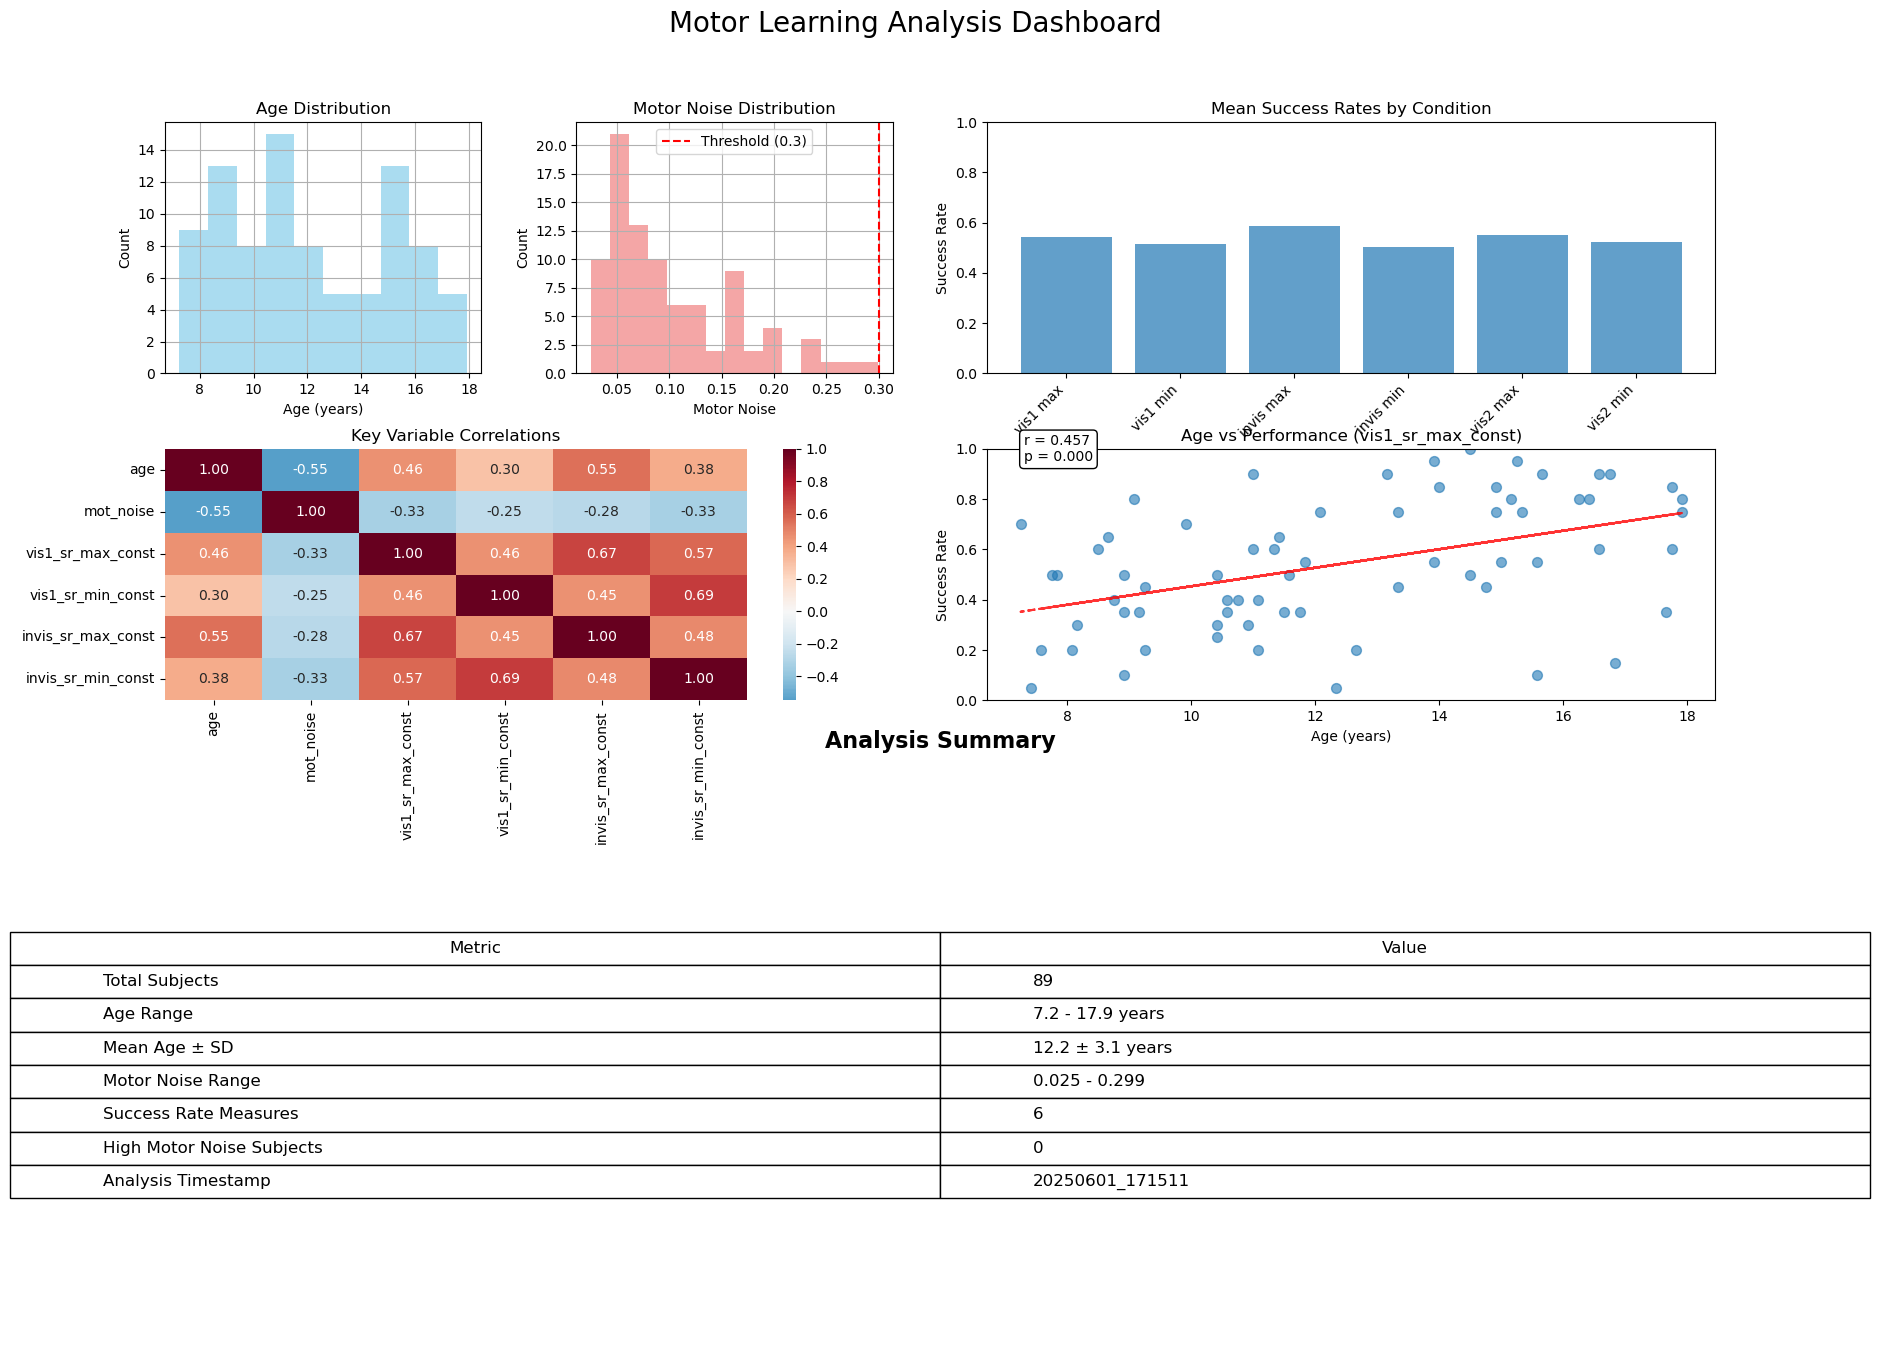

   Generated summary dashboard: analysis_dashboard_20250601_171511.png

✅ Generated 260 plots total

💾 STEP 4: EXPORTING RESULTS
--------------------------------------------------
📊 Metrics CSV: metrics_20250601_171511.csv
❌ Export failed: Object of type bool_ is not JSON serializable

🎉 INTEGRATED PIPELINE COMPLETED SUCCESSFULLY!
⏰ Completed at: 2025-06-01 17:17:33
✅ Steps completed: 4/4
📁 Results saved to: analysis


In [12]:
# 5. CORRECTED: Create integrated pipeline with STRING output directory
# Option 1: Use the same directory as config
pipeline = IntegratedMotorLearningPipeline(analysis, str(config.BASE_OUTPUT_DIR))

# OR Option 2: Use a different directory name
# pipeline = IntegratedMotorLearningPipeline(analysis, 'integrated_analysis_output')

print(f"✅ Pipeline ready!")

# 6. Run the full pipeline
print("\n🚀 Running integrated analysis pipeline...")
pipeline_results = pipeline.run_complete_analysis()